# Statistical analysis of models for division-replication coordination

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, optimize, integrate
import pandas as pd
import ot
import cma
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

## 1. Data extraction

In [2]:
data_si_mg_acet = pd.read_excel("1-s2.0-S0960982219304919-mmc3.xlsx",sheet_name = 'MG1655 M9 acetate', header=None)
data_si_mg_acet = np.array(data_si_mg_acet)

data_si_mg_glu = pd.read_excel("1-s2.0-S0960982219304919-mmc3.xlsx",sheet_name = 'MG1655 MOPS glucose', header=None)
data_si_mg_glu = np.array(data_si_mg_glu)
# the cell cycle 308 has been withdrawn because of a negative C+D period
data_si_mg_glu = np.delete(data_si_mg_glu, 308, axis = 0) 

data_si_mg_gly11aa = pd.read_excel("1-s2.0-S0960982219304919-mmc3.xlsx",sheet_name = 'MG1655 MOPS glycerol 11aa', header=None)
data_si_mg_gly11aa = np.array(data_si_mg_gly11aa)

data_si_ncm_arg = pd.read_excel("1-s2.0-S0960982219304919-mmc3.xlsx",sheet_name = 'NCM3722 MOPS arginine', header=None)
data_si_ncm_arg = np.array(data_si_ncm_arg)

data_si_ncm_glu12aa = pd.read_excel("1-s2.0-S0960982219304919-mmc3.xlsx",sheet_name = 'NCM3722 MOPS glucose 12aa', header=None)
data_si_ncm_glu12aa = np.array(data_si_ncm_glu12aa)

data_si_ncm_glu = pd.read_excel("1-s2.0-S0960982219304919-mmc3.xlsx",sheet_name = 'NCM3722 MOPS glucose', header=None)
data_si_ncm_glu = np.array(data_si_ncm_glu)

data_Tiruvadi_JM85_Gly = pd.read_csv("Fig1-2_Data/JM85(ssb-mYpet)_Gly.txt", sep = '\t', header = None)
data_Tiruvadi_JM85_Gly = np.array(data_Tiruvadi_JM85_Gly)

data_Tiruvadi_STK13_Ace = pd.read_csv("Fig1-2_Data/STK13(DnaN-FtsN)_Ace.txt", sep = '\t', header = None)
data_Tiruvadi_STK13_Ace = np.array(data_Tiruvadi_STK13_Ace)

data_Tiruvadi_STK13_AlaTrE = pd.read_csv("Fig1-2_Data/STK13(DnaN-FtsN)_AlaTrE.txt", sep = '\t', header = None)
data_Tiruvadi_STK13_AlaTrE = np.array(data_Tiruvadi_STK13_AlaTrE)

data_Tiruvadi_STK13_Glu = pd.read_csv("Fig1-2_Data/STK13(DnaN-FtsN)_Glu.txt", sep = '\t', header = None)
data_Tiruvadi_STK13_Glu = np.array(data_Tiruvadi_STK13_Glu)

data_Tiruvadi_STK13_GlyCas= pd.read_csv("Fig1-2_Data/STK13(DnaN-FtsN)_GlyCas.txt", sep = '\t', header = None)
data_Tiruvadi_STK13_GlyCas = np.array(data_Tiruvadi_STK13_GlyCas)

data_Tiruvadi_STK13_GlyTrE= pd.read_csv("Fig1-2_Data/STK13(DnaN-FtsN)_GlyTrE.txt", sep = '\t', header = None)
data_Tiruvadi_STK13_GlyTrE = np.array(data_Tiruvadi_STK13_GlyTrE)

data_Tiruvadi_STK13_Man= pd.read_csv("Fig1-2_Data/STK13(DnaN-FtsN)_Man.txt", sep = '\t', header = None)
data_Tiruvadi_STK13_Man = np.array(data_Tiruvadi_STK13_Man)
# the cell cycles 191 and 199 have been withdrawn because of a negative C+D period and 
# cell cycle 275 has been withdrawn because of a negative elongation rate
data_Tiruvadi_STK13_Man = np.delete(data_Tiruvadi_STK13_Man, (191, 199, 275), axis = 0)

data_Tiruvadi_JM85_GluCas = pd.read_csv("Fig1-2_Data/JM85(ssb-mYpet)_GluCas.txt", sep = '\t', header = None)
data_Tiruvadi_JM85_GluCas = np.array(data_Tiruvadi_JM85_GluCas)

data_witz = pd.read_csv('Fig1_2_3.csv', header = None) 
[Lb, dL, Li, Li_prev, dLambda_if, lambda_inv, Tid, dLambda_id, Lb_mother, condition] = range(0, 10)

We define a function that takes into argument the dataset (or the growth condition either 'glycerol', 'glucose' or 'glucose8a' if the data comes from Witz et al. (2019)), and returns a dictionary gathering four cell variables: 
- the size at birth ($V_b^{(\bullet)}$)
- the size per origin at replication initiation ($\tilde{V}_i^{(\bullet)}$)
- The size at division ($2V_b^{(\bullet+1)}$)
- the elongation rate over the C+D period ($\Lambda^{(\bullet)}$) computed as $\log(V_b^{(\bullet+1)}/\tilde{V}_i^{(\bullet)})/(T_b^{(\bullet+1)} - T_i^{(\bullet)})$ , with $T_b^{(\bullet+1)} - T_i^{(\bullet)}$ being the C+D period.

Examples for use:

extract_data(data_si_mops_acet, 'Si et al.')

extract_data(data_Tiruvadi_JM85_GluCas, 'Tiruvadi et al.')

extract_data('glycerol', 'Witz et al.')



In [3]:
def extract_data(data_or_cdt, authors):
    if authors == 'Si et al.':
        data = data_or_cdt
        vb = data[1:, data[0] == 'newborn size (micron)'].astype(float)
        vi = data[1:, data[0] == 'initiation size per ori (micron)'].astype(float)/2.
        vd = data[1:, data[0] == 'division size (micron)'].astype(float)
        TCD = data[1:, data[0] == 'tau_cyc (minute)'].astype(float)/60.
        Lamb = np.log(vd/(2*vi))/TCD
        return {'Size at birth' : vb, 
                'Size at initiation per ori' : vi, 
                'Size at division' : vd, 
                'Elongation rate over C+D period' : Lamb}
    
    elif authors == 'Tiruvadi et al.':
        data = data_or_cdt
        vb = data[1:, data[0] == 'Lb'].astype(float)
        vi = data[1:, data[0] == 'Lri'].astype(float)/2.
        vd = data[1:, data[0] == 'Ld'].astype(float)
        Tri = data[1:, data[0] == 'Tri'].astype(float)
        Td = data[1:, data[0] == 'Td'].astype(float)
        TCD = (Td - Tri)/60.
        Lamb = np.log(vd/(2*vi))/TCD
        return {'Size at birth' : vb, 
                'Size at initiation per ori' : vi, 
                'Size at division' : vd, 
                'Elongation rate over C+D period' : Lamb}
    
    elif authors == 'Witz et al.':
        data = data_witz[data_witz[condition] == data_or_cdt]
        data = data.dropna(subset = (Lb, dL, Li, Tid))
        data = data.to_numpy()
        data = data[:,:-1].astype(float)
        TCD = data[:, Tid]/60.
        vb = data[:, Lb]
        vd = vb + data[:, dL]
        vi = data[:, Li]/2.
        Lamb = np.log(vd/(2*vi))/TCD
        return {'Size at birth' : vb, 
                'Size at initiation per ori' : vi, 
                'Size at division' : vd, 
                'Elongation rate over C+D period' : Lamb}

For every dataset we apply the function extract_data.

In [4]:
MG_acet = extract_data(data_si_mg_acet, 'Si et al.')
MG_gly11a = extract_data(data_si_mg_gly11aa, 'Si et al.')
MG_glu = extract_data(data_si_mg_glu, 'Si et al.')

NCM_arg = extract_data(data_si_ncm_arg, 'Si et al.')
NCM_glu = extract_data(data_si_ncm_glu, 'Si et al.')
NCM_glu12a = extract_data(data_si_ncm_glu12aa, 'Si et al.')

JM_gly = extract_data(data_Tiruvadi_JM85_Gly, 'Tiruvadi et al.')
JM_gluCas = extract_data(data_Tiruvadi_JM85_GluCas, 'Tiruvadi et al.')

STK_acet = extract_data(data_Tiruvadi_STK13_Ace, 'Tiruvadi et al.')
STK_alaTre = extract_data(data_Tiruvadi_STK13_AlaTrE, 'Tiruvadi et al.')
STK_glu = extract_data(data_Tiruvadi_STK13_Glu, 'Tiruvadi et al.')
STK_glyCas = extract_data(data_Tiruvadi_STK13_GlyCas, 'Tiruvadi et al.')
STK_glyTre = extract_data(data_Tiruvadi_STK13_GlyTrE, 'Tiruvadi et al.')
STK_man = extract_data(data_Tiruvadi_STK13_Man, 'Tiruvadi et al.')

BW_gly = extract_data('glycerol', 'Witz et al.')
BW_glu = extract_data('glucose', 'Witz et al.')
BW_glu8a = extract_data('glucose8a', 'Witz et al.')

DATA = [MG_acet, MG_gly11a, MG_glu, NCM_arg, NCM_glu, NCM_glu12a, BW_gly, BW_glu, BW_glu8a, STK_acet, STK_alaTre, STK_man, JM_gly, STK_glyTre, STK_glu, STK_glyCas, JM_gluCas]

Labels = ['MG1655 acet', 'MG1655 gly11aa', 'MG1655 glu', 'NCM3722 arg', 'NCM3722 glu', 'NCM3722 glu12aa', 'BW27378 gly', 'BW27378 glu', 'BW27378 glu8a', 'BW27783 acet', 'BW27783 alaTrE', 'BW27783 man', 'BW27783 gly', 'BW27783 glyTre', 'BW27783 glu', 'BW27783 glyCas', 'BW27783 gluCas']

## 2. Preliminary analysis

The cell variables that have been previously extracted have so far extensively been studied through correlation analysis. Independance between these variables (or some linear combinations of these) have been deduced from zero correlations, which holds only if these variables ar Normaly distributed. Here we check whether this condition is satisfied through a Shapiro-Wilk normality tests for the division, birth and initiation sizes. 

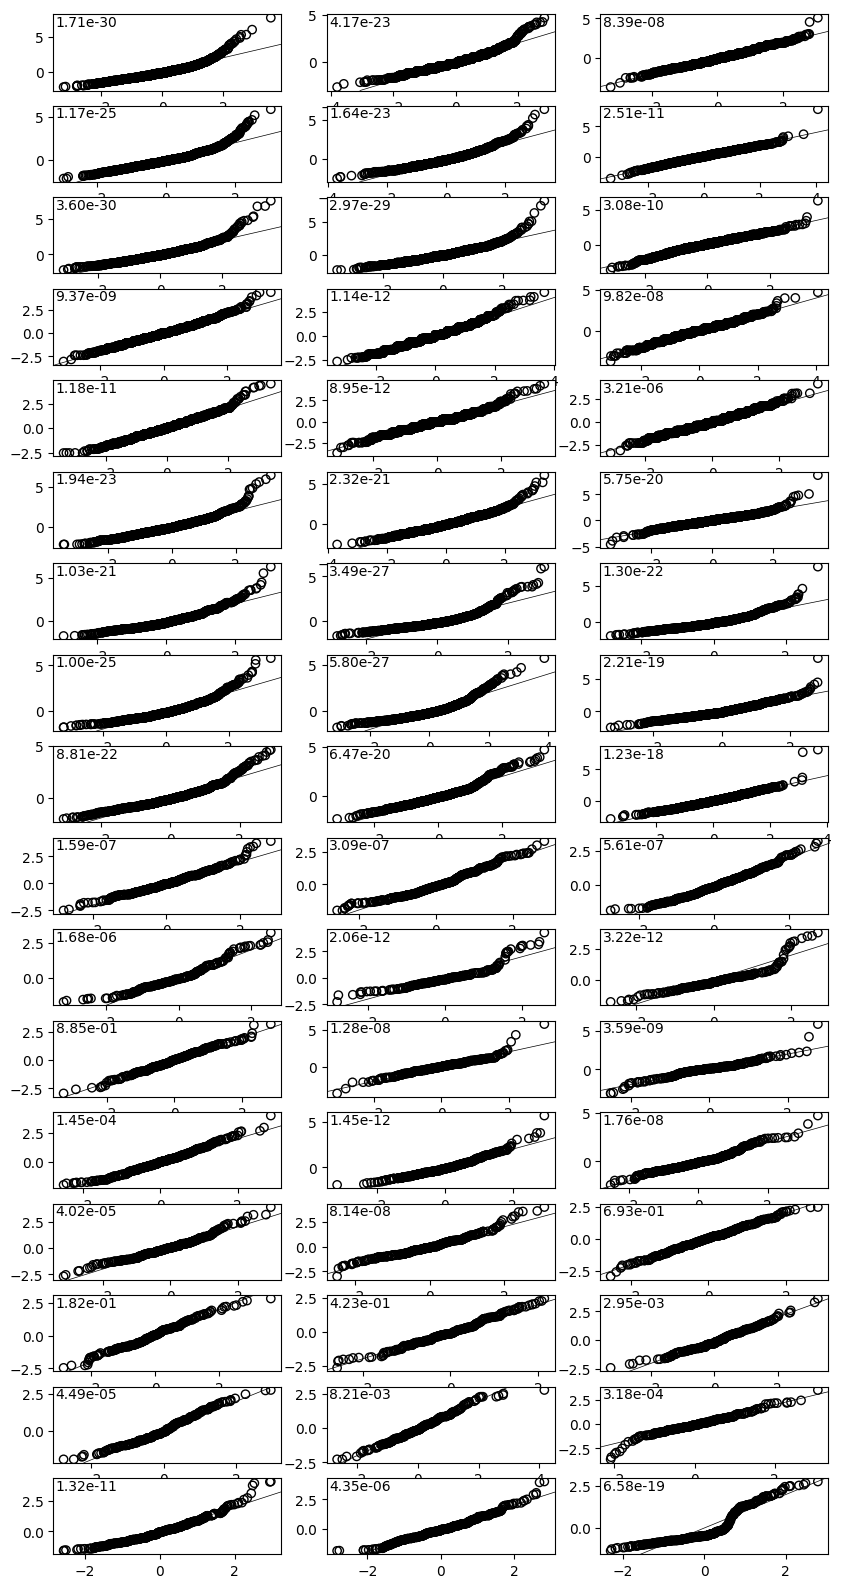

In [5]:
def qqplot_norm(values):
    N = np.size(values)
    mean = np.mean(values)
    std = np.std(values)
    Y = np.sort((values - mean)/std)
    X = np.sort(stats.norm.rvs(size = N))
    plt.axline((0, 0), slope=1, color="k", linewidth = 0.5)
    plt.scatter(X, Y, c = 'None', edgecolors = 'k')

pvalue_vd_norm_test = []
pvalue_vb_norm_test = []
pvalue_vi_norm_test = []

np.random.seed(123)

plt.figure(figsize = (10, 20))
k = 0
for data in DATA:
    vd = data['Size at division'].flatten()
    vb = data['Size at birth'].flatten()
    vi = data['Size at initiation per ori'].flatten()
    plt.subplot(17,3,3*k+1)
    qqplot_norm(vd)
    pv = stats.shapiro(vd).pvalue
    pvalue_vd_norm_test.append(f"{pv:.2e}")
    plt.text(0.01, 0.99, f'{pv:.2e}', transform=plt.gca().transAxes, ha='left', va='top')
    plt.subplot(17,3,3*k+2)
    qqplot_norm(vb)
    pv = stats.shapiro(vb).pvalue
    pvalue_vb_norm_test.append(f"{pv:.2e}")
    plt.text(0.01, 0.99, f'{pv:.2e}', transform=plt.gca().transAxes, ha='left', va='top')
    plt.subplot(17,3,3*k+3)
    qqplot_norm(vi)
    pv = stats.shapiro(vi).pvalue
    pvalue_vi_norm_test.append(f"{pv:.2e}")
    plt.text(0.01, 0.99, f'{pv:.2e}', transform=plt.gca().transAxes, ha='left', va='top')
    k+=1

In [6]:
pvalue_norm_test = [[''] + Labels]
pvalue_norm_test.append(['$V_d$'] + pvalue_vd_norm_test)
pvalue_norm_test.append(['$V_b$'] + pvalue_vb_norm_test)
pvalue_norm_test.append(['$\tilde{V}_i$'] + pvalue_vi_norm_test)
pvalue_norm_test = np.array(pvalue_norm_test, dtype = object).T
pd.DataFrame(data = pvalue_norm_test[1:,1:], index = pvalue_norm_test[1:,0], columns = pvalue_norm_test[0, 1:])

$V_d$     $V_b$ $\tilde{V}_i$
MG1655 acet      1.71e-30  4.17e-23      8.39e-08
MG1655 gly11aa   1.17e-25  1.64e-23      2.51e-11
MG1655 glu       3.60e-30  2.97e-29      3.08e-10
NCM3722 arg      9.37e-09  1.14e-12      9.82e-08
NCM3722 glu      1.18e-11  8.95e-12      3.21e-06
NCM3722 glu12aa  1.94e-23  2.32e-21      5.75e-20
BW27378 gly      1.03e-21  3.49e-27      1.30e-22
BW27378 glu      1.00e-25  5.80e-27      2.21e-19
BW27378 glu8a    8.81e-22  6.47e-20      1.23e-18
BW27783 acet     1.59e-07  3.09e-07      5.61e-07
BW27783 alaTrE   1.68e-06  2.06e-12      3.22e-12
BW27783 man      8.85e-01  1.28e-08      3.59e-09
BW27783 gly      1.45e-04  1.45e-12      1.76e-08
BW27783 glyTre   4.02e-05  8.14e-08      6.93e-01
BW27783 glu      1.82e-01  4.23e-01      2.95e-03
BW27783 glyCas   4.49e-05  8.21e-03      3.18e-04
BW27783 gluCas   1.32e-11  4.35e-06      6.58e-19

Then, we showed that the distributions of the latent variables of the CPM and the CAM are identifiable if in the datasets we observe two triplets of measurements of the birth size, initiation size and elongation rate over the C+D period $(v_b^1, \tilde{v}_i^1, \lambda^1)$ and $(v_b^2, \tilde{v}_i^2, \lambda^2)$ that satisfy:
$$v_b^1 < v_b^2, \quad \tilde{v}_i^2 < \tilde{v}_b^1, \quad \lambda^2< \lambda^1.$$

Here we check whether this condition is satisfied in every dataset.

In [7]:
def check_identifiblity(data):
    vb = data['Size at birth']
    vi = data['Size at initiation per ori']
    Lamb = data['Elongation rate over C+D period']
    N = np.size(vb)
    for k in range(N):
        for l in range(N):
            if (vi[k]<vi[l])&(vb[l]<vb[k])&(Lamb[k]<Lamb[l]):
                return 'Identifiable'
    return 'not Identifiable'

for data in DATA:
    print(check_identifiblity(data))

Identifiable
Identifiable
Identifiable
Identifiable
Identifiable
Identifiable
Identifiable
Identifiable
Identifiable
Identifiable
Identifiable
Identifiable
Identifiable
Identifiable
Identifiable
Identifiable
Identifiable


## 3. Auxiliary functions

In [8]:
#The following functions compute the pdf, cdf, and their logarithm given parameters lambda, beta and sigma.
def GenGamma_logpdf(x, lamb, beta, sigma):
    x = np.atleast_1d(x)
    if abs(lamb) < 1e-3:
        return stats.lognorm.logpdf(x, s = sigma, scale = np.exp(beta))
    else:
        logrescaled_x = (lamb/sigma)*(np.log(x) - beta) - 2*np.log(abs(lamb))
        logrescaled_x[(logrescaled_x > 709.78)|(logrescaled_x < -745.13)] = np.nan
        return stats.loggamma.logpdf(logrescaled_x, c = 1/lamb**2, scale = 1) + np.log(abs(lamb)/sigma) - np.log(x)

def GenGamma_logcdf(x, lamb, beta, sigma):
    x = np.atleast_1d(x)
    if abs(lamb) <= 1e-3:
        return stats.lognorm.logcdf(x, s = sigma, scale = np.exp(beta))    
    elif lamb > 1e-3:
        logrescaled_x = (lamb/sigma)*(np.log(x) - beta) - 2*np.log(abs(lamb))
        logrescaled_x[(logrescaled_x > 709.78)|(logrescaled_x < -745.13)] = np.nan
        return stats.loggamma.logcdf(logrescaled_x, c = 1/lamb**2, scale = 1)
    else:
        logrescaled_x = (lamb/sigma)*(np.log(x) - beta) - 2*np.log(abs(lamb))
        logrescaled_x[(logrescaled_x > 709.78)|(logrescaled_x < -745.13)] = np.nan
        return stats.loggamma.logsf(logrescaled_x, c = 1/lamb**2, scale = 1)
        
def GenGamma_pdf(x, lamb, beta, sigma):
    return np.nan_to_num(np.exp(GenGamma_logpdf(x, lamb, beta, sigma)))

def GenGamma_cdf(x, lamb, beta, sigma):
    return np.nan_to_num(np.exp(GenGamma_logcdf(x, lamb, beta, sigma)))

# We define a function that simulates random variables distributed according to a Generalized Gamma 
# distribution of parameters lamb, beta, sigma.
def GenGamma_rvs(size, lamb, beta, sigma):
    if abs(lamb) < 1e-2:
        return stats.lognorm.rvs(size = size, s = sigma, scale = np.exp(beta))
    else :
        a = 1/lamb**2
        c = lamb / sigma
        scale = np.exp(beta)*abs(lamb)**(2/c)
        return stats.gengamma.rvs(size = size, a = a, c = c, scale = scale)

def GenGamma_moments(lamb, beta, sigma):
    a = 1/lamb**2
    c = lamb / sigma
    scale = np.exp(beta)*abs(lamb)**(2/c)
    return (stats.gengamma.mean(a = a, c = c, scale = scale), stats.gengamma.var(a = a, c = c, scale = scale))

# We define a function that returns parameters of Generalized Gamma distribution suited for a 
# set of values (data) to initialize the fit of a Generalized Gamma distribution on that set of values.
def init_GenGamma_fit(data):
    mean = np.mean(data)
    CV = np.std(data)/mean
    minlklh = 0
    while minlklh == 0:
        lamb = np.random.normal()
        beta = np.log(mean)
        sigma = CV
        minlklh = np.min(GenGamma_pdf(data, lamb, beta, sigma))
    return lamb, beta, sigma


# We define a function able to minimize functions that involve GenGamma_logpdf or 
# GenGamma_logcdf of parameters X0 which are not well defined for lambda close to zero.
def GenGamma_minimize(f, X0):
    [lamb,_,_] = X0
    if abs(lamb) <= 0.01:
        results = cma.fmin(f, X0, sigma0 = 1, options = {'verbose': -9, 'bounds': [[None, None, 0], [None, None, None]]})
        return results[0]
    else:
        results = optimize.minimize(f, X0, method = 'Nelder-Mead')
        return results.x


# We define a function that estimates by maximum of likelihood the parameters
# of a Generalized Gamma distribution over a set of values
def GenGamma_fit(values):
    def f(X):
        [lamb, beta, sigma] = X
        return -np.sum(GenGamma_logpdf(values, lamb, beta, sigma))
    lamb, beta, sigma = 1,1,1
    best_lklh = np.sum(GenGamma_logpdf(values, 1, 1, 1))
    for loop in range(15):
        l, b, s = init_GenGamma_fit(values)
        [l, b, s] = GenGamma_minimize(f, [l, b, s])
        lklh = np.sum(GenGamma_logpdf(values, l, b, s))
        if best_lklh < lklh:
            best_lklh = lklh
            lamb, beta, sigma = l, b, s
    return lamb, beta, sigma

# We define functions that simulate division size given cell covariates according to the CPM and CAM
def simu_division_size_CPM(vb, vi, Lamb, param):
    size = np.shape(vb)
    [lamb_d, beta_d, sig_d, lamb_r, beta_r, sig_r]  = param
    R = GenGamma_rvs(size = size, lamb = lamb_r, beta = beta_r, sigma = sig_r)
    Delta_d = GenGamma_rvs(size = size, lamb = lamb_d, beta = beta_d, sigma = sig_d)
    return np.maximum(2*vi*np.exp(Lamb*R), vb + Delta_d)

def simu_division_size_CAM(vb, vi, param):
    size = np.shape(vb)
    [lamb_d, beta_d, sig_d, lamb_id, beta_id, sig_id]  = param
    Delta_id = GenGamma_rvs(size = size, lamb = lamb_id, beta = beta_id, sigma = sig_id)
    Delta_d = GenGamma_rvs(size = size, lamb = lamb_d, beta = beta_d, sigma = sig_d)
    return np.maximum(2*(vi + Delta_id), vb + Delta_d)

# The following functions are customed for figures
def histogram(data, color, alpha):
    mean = np.mean(data)
    std = np.std(data)
    N = 3*np.size(data)**(1/3.)
    plt.hist(data, bins = int(N), range = (np.min(data), min([np.max(data), mean+ 3*std, 2*mean])), density = True, color = color, alpha = alpha)

# This function allows to plot significance asterisks on Wasserstein plots
def significance_asterisk(p_value, x, y, y1, y2):
    plt.plot([x-0.15, x-0.15, x+0.15, x+0.15], [y1, y, y, y2], 'k', linewidth = 0.5)
    if p_value < 0.001:
        plt.text(x, y, '***', ha='center', color='k',fontsize=15)
    elif p_value < 0.01:
        plt.text(x, y, '**', ha='center', color='k',fontsize=15)
    elif p_value < 0.05:
        plt.text(x, y, '*', ha='center', color='k',fontsize=15)

## 4. Parameters estimation and BIC/AIC computation

In the following the i.i.d. random variables involved in the DIAM, RDAM, CPM, and CPM, namely $\Delta_d$, $\Delta_{id}$, and $R$ are supposed to be distributed according to Generalized Gamma distributions defined by the density $f$, $\forall x >0$

$\lambda \neq 0, \beta \in \mathbb{R}, \sigma \in \mathbb{R}_+^*,$
$$f(x) = \frac{|\lambda|}{\sigma x \Gamma(\lambda^{-2})} \left(\lambda^{-2} \Big( \frac{x}{e^\beta}\Big)^{\frac{\lambda}{\sigma}}\right)^{\lambda^{-2}} \exp\left(-\lambda^{-2} \Big( \frac{x}{e^\beta}\Big)^{\frac{\lambda}{\sigma}}\right).$$

In the following sections we estimate the parameters in the distributions of the i.i.d. random variables for every model. While for the DIAM and the RDAM, we rely on the fit function of the Scipy.stats library, for the CPM and the CAM, we rely on an EM algorithm involving optimization algorithms such as Nelder-Mead from the package Scipy.optimize, and CMA-ES from the package cma.

### Parameters estimation and BIC/AIC computation for DIAM and RDAM

In [9]:
def estim_param_DIAM(data):
    Delta_d = data['Size at division'] - data['Size at birth']
    lamb, beta, sigma = GenGamma_fit(Delta_d)
    lklh = np.sum(GenGamma_logpdf(Delta_d, lamb, beta, sigma))
    BIC = - lklh + 3*np.log(np.size(Delta_d))/2.
    AIC = - lklh + 3
    return [[lamb, beta, sigma], AIC, BIC]

In [10]:
def estim_param_RDAM(data):
    Delta_id = data['Size at division']/2. - data['Size at initiation per ori']
    lamb, beta, sigma = GenGamma_fit(Delta_id)
    lklh = np.sum(GenGamma_logpdf(Delta_id, lamb, beta, sigma) - np.log(2)) 
    BIC = - lklh + 3*np.log(np.size(Delta_id))/2.
    AIC = - lklh + 3
    return [[lamb, beta, sigma], AIC, BIC]

In [11]:
def estim_param_HoAmir(data):
    vd = data['Size at division']
    Lamb = data['Elongation rate over C+D period']
    TCD = np.log(vd/(2*data['Size at initiation per ori']))/Lamb
    lamb, beta, sigma = GenGamma_fit(TCD)
    lklh = np.sum(GenGamma_logpdf(TCD, lamb, beta, sigma) - np.log(vd*Lamb)) 
    BIC = - lklh + 3*np.log(np.size(TCD))/2.
    AIC = - lklh + 3
    return [[lamb, beta, sigma], AIC, BIC]

In [12]:
Results_parameters_estimation_DIAM = {'parameters' : [], 'AIC' : [], 'BIC' : []}
Results_parameters_estimation_RDAM = {'parameters' : [], 'AIC' : [], 'BIC' : []}
Results_parameters_estimation_HoAmir = {'parameters' : [], 'AIC' : [], 'BIC' : []}

for data in DATA:
    res_DIAM = estim_param_DIAM(data) 
    Results_parameters_estimation_DIAM['parameters'].append(res_DIAM[0]) 
    Results_parameters_estimation_DIAM['AIC'].append(res_DIAM[1]) 
    Results_parameters_estimation_DIAM['BIC'].append(res_DIAM[2])
    res_RDAM = estim_param_RDAM(data)
    Results_parameters_estimation_RDAM['parameters'].append(res_RDAM[0]) 
    Results_parameters_estimation_RDAM['AIC'].append(res_RDAM[1]) 
    Results_parameters_estimation_RDAM['BIC'].append(res_RDAM[2])
    res_HoAmir = estim_param_HoAmir(data)
    Results_parameters_estimation_HoAmir['parameters'].append(res_HoAmir[0]) 
    Results_parameters_estimation_HoAmir['AIC'].append(res_HoAmir[1]) 
    Results_parameters_estimation_HoAmir['BIC'].append(res_HoAmir[2])

In [13]:
BIC = [[''] + Labels]
BIC.append(['DIAM'] + Results_parameters_estimation_DIAM['BIC'])
BIC.append(['RDAM'] + Results_parameters_estimation_RDAM['BIC'])
BIC.append(['HoAmir'] + Results_parameters_estimation_HoAmir['BIC'])
BIC = np.array(BIC, dtype = object).T
pd.DataFrame(data = BIC[1:,1:], index = BIC[1:,0], columns = BIC[0, 1:])

DIAM         RDAM       HoAmir
MG1655 acet       677.416403   445.543043  1311.979223
MG1655 gly11aa   1233.281403  1494.293427  2513.408823
MG1655 glu       1169.802747  1364.290082   2589.92206
NCM3722 arg      -253.429324  -358.506203  -261.017929
NCM3722 glu       269.031102   378.460234   512.802429
NCM3722 glu12aa   989.382483  1241.541014  1569.755692
BW27378 gly       140.213801   101.205679   384.982905
BW27378 glu       412.904456   630.589503   927.786957
BW27378 glu8a     766.688609   886.778557  1233.240925
BW27783 acet       54.274909   -37.541371   127.724276
BW27783 alaTrE     68.098162    14.180474   102.318241
BW27783 man       113.999075    108.89743   237.861137
BW27783 gly       179.264413   131.057067   343.452247
BW27783 glyTre     59.713358    31.281993   241.530982
BW27783 glu       125.566577   123.974912   240.971124
BW27783 glyCas    193.604843   252.144927   317.965943
BW27783 gluCas    359.898604    471.71771     686.9342

/var/folders/pv/dyn_j89n1wjbmtr1l8kdhs680000gn/T/ipykernel_54185/105238833.py:20: RuntimeWarning: invalid value encountered in log
  logrescaled_x = (lamb/sigma)*(np.log(x) - beta) - 2*np.log(abs(lamb))
/var/folders/pv/dyn_j89n1wjbmtr1l8kdhs680000gn/T/ipykernel_54185/105238833.py:16: RuntimeWarning: invalid value encountered in log
  logrescaled_x = (lamb/sigma)*(np.log(x) - beta) - 2*np.log(abs(lamb))


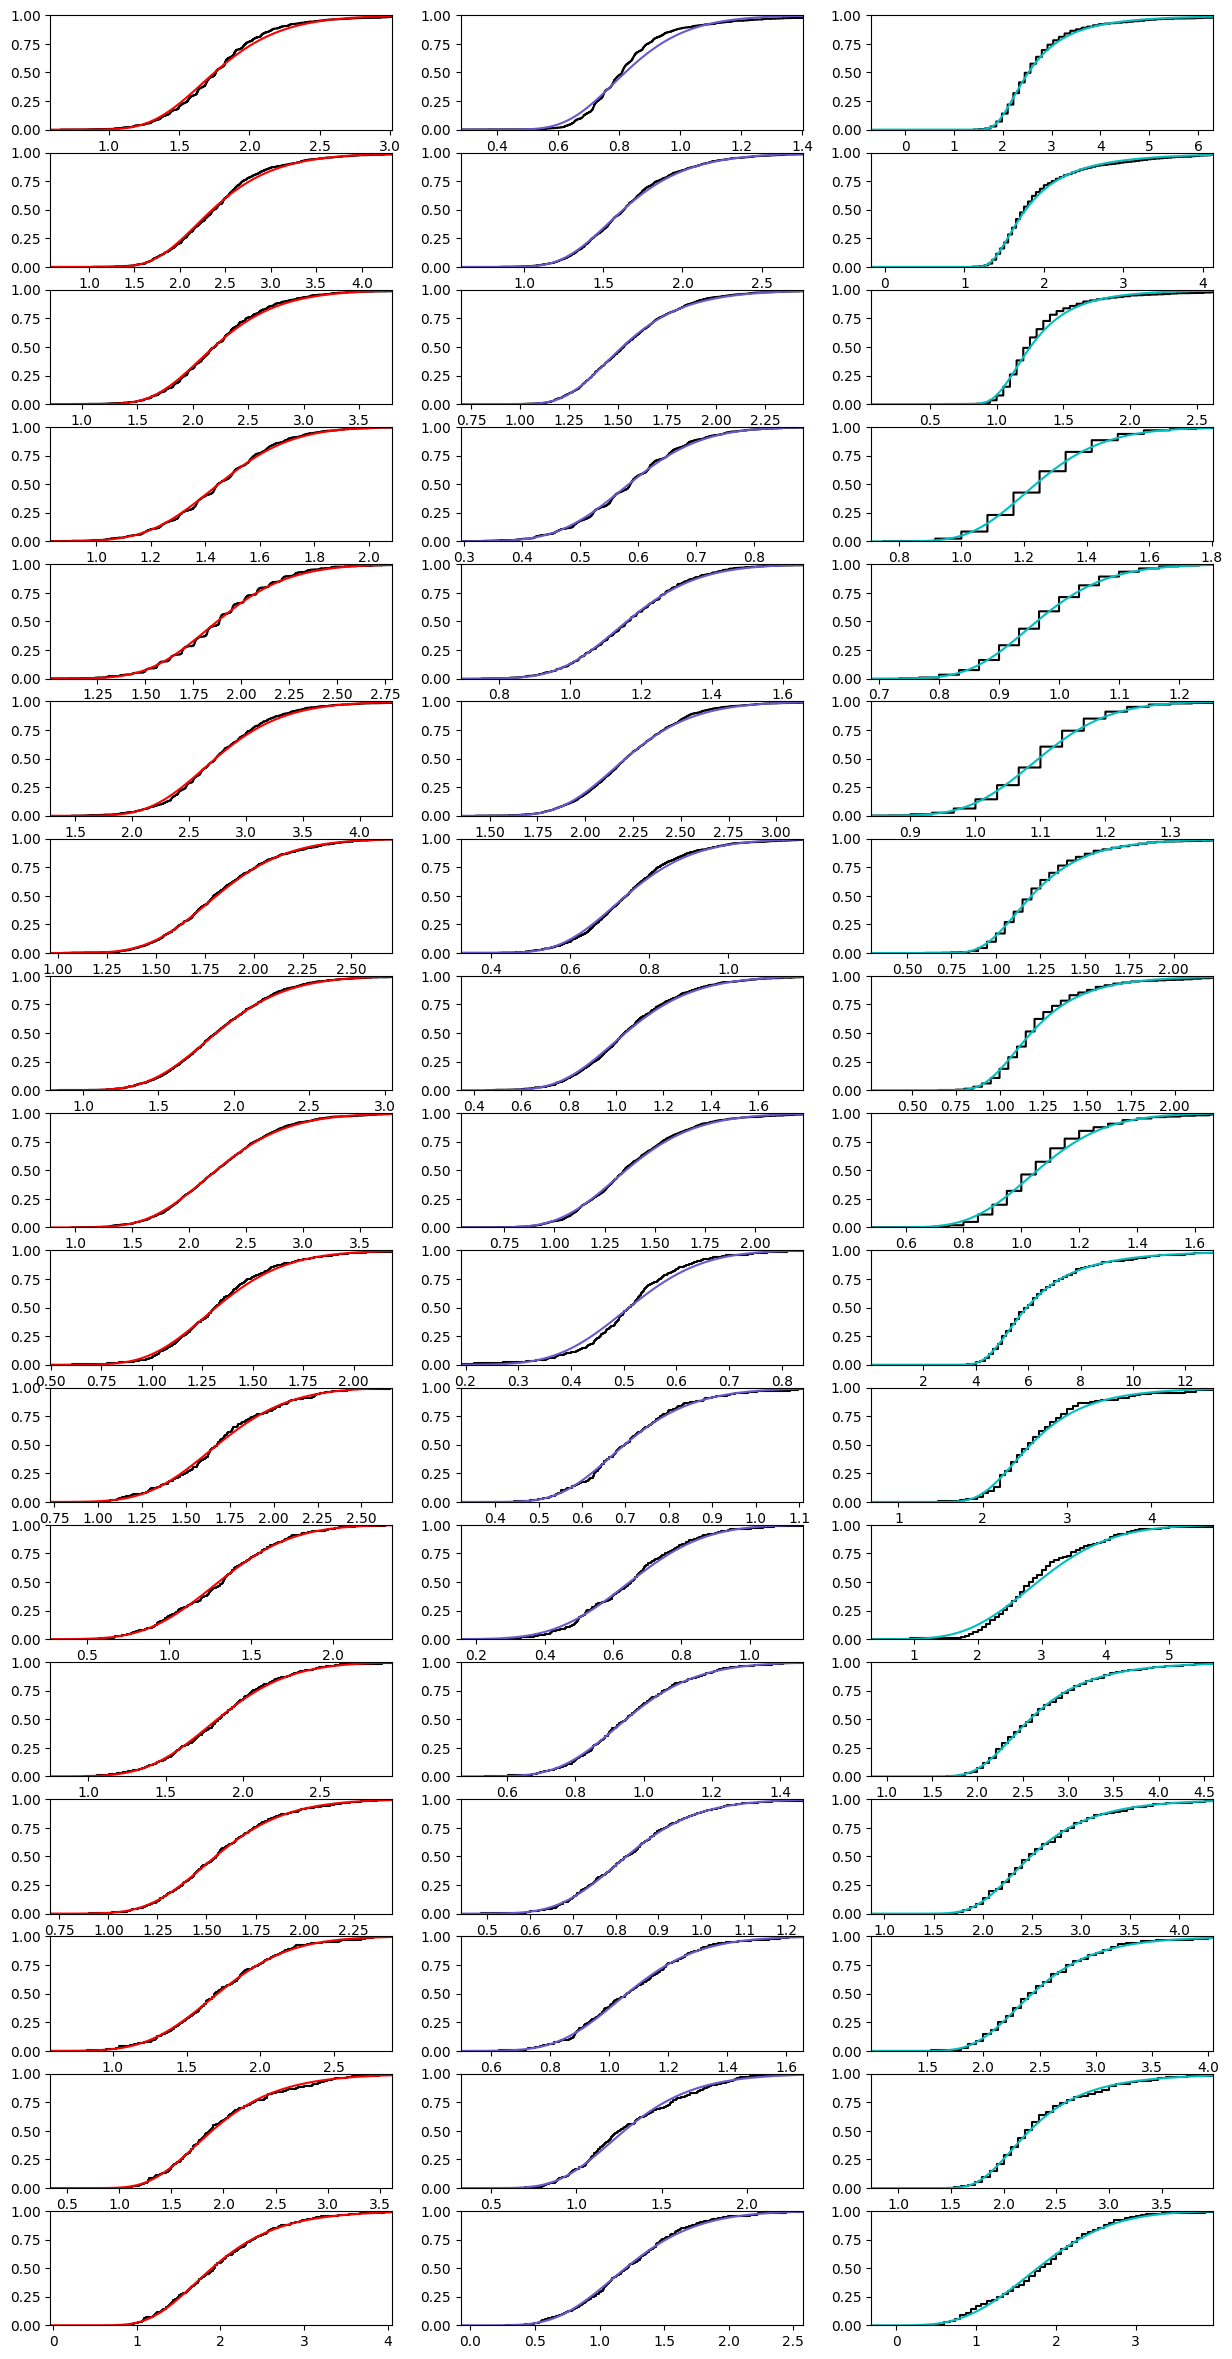

In [14]:
plt.figure(figsize = (15,30))
k = 0
for data in DATA:
    Delta_d = data['Size at division'] - data['Size at birth']
    Delta_d = Delta_d.flatten()
    mean_d = np.mean(Delta_d)
    std_d = np.std(Delta_d)
    Ddplot = np.linspace(mean_d - 3*std_d, mean_d + 3*std_d, 100)
    [lamb_d, beta_d, scale_d] = Results_parameters_estimation_DIAM['parameters'][k]
        
    plt.subplot(17, 3, 3*k+1)
    plt.ecdf(Delta_d, color = 'k')
    plt.plot(Ddplot, GenGamma_cdf(Ddplot, lamb_d, beta_d, scale_d), 'r')
    plt.xlim(mean_d - 3*std_d, mean_d + 3*std_d)

        
    Delta_id = data['Size at division']/2. - data['Size at initiation per ori']
    Delta_id = Delta_id.flatten()
    mean_id = np.mean(Delta_id)
    std_id = np.std(Delta_id)
    Didplot = np.linspace(mean_id - 3*std_id, mean_id + 3*std_id, 100)
    [lamb_id, beta_id, scale_id] = Results_parameters_estimation_RDAM['parameters'][k]
        
    plt.subplot(17, 3, 3*k+2)
    plt.ecdf(Delta_id, color = 'k')
    plt.plot(Didplot, GenGamma_cdf(Didplot, lamb_id, beta_id, scale_id), 'slateblue')
    plt.xlim(mean_id - 3*std_id, mean_id + 3*std_id)
        
    R = np.log(data['Size at division']/(2*data['Size at initiation per ori']))/data['Elongation rate over C+D period']
    R = R.flatten()
    mean_r = np.mean(R)
    std_r = np.std(R)
    Rplot = np.linspace(mean_r - 3*std_r, mean_r + 3*std_r, 100)
    lamb_r, beta_r, scale_r = GenGamma_fit(R)
        
    plt.subplot(17, 3, 3*k+3)
    plt.ecdf(R, color = 'k')
    plt.plot(Rplot, GenGamma_cdf(Rplot, lamb_r, beta_r, scale_r), 'c')
    plt.xlim(mean_r - 3*std_r, mean_r + 3*std_r)
    k+=1
plt.savefig('fitGenGamma_Dd_Did_R.pdf', format = 'pdf')
plt.show()

### Parameters estimation and BIC/AIC computation for the CPM

Since the maximization of the likelihood of the CPM can be difficult, we propose an expectation-maximization (EM) algorithm that circumvents the difficulties in estimating the parameters of the distributions of the CPM.
This algorithm consists in iterative maximizations 

In [15]:
def CPM_EM(data):
    vd = data['Size at division']
    Delta_d_app = vd - data['Size at birth']
    Lamb = data['Elongation rate over C+D period']
    TCD = np.log(vd/(2*data['Size at initiation per ori']))/Lamb
    
    def f_DIV(X):
        [lamb_d, beta_d, sigma_d, lamb_r, beta_r, sigma_r] = X
        f_Dd = GenGamma_pdf(Delta_d_app, lamb_d, beta_d, sigma_d)
        F_R = GenGamma_cdf(TCD, lamb_r, beta_r, sigma_r)
        return f_Dd*F_R

    def f_REP(X):
        [lamb_d, beta_d, sigma_d, lamb_r, beta_r, sigma_r] = X
        F_Dd = GenGamma_cdf(Delta_d_app, lamb_d, beta_d, sigma_d)
        f_R = GenGamma_pdf(TCD, lamb_r, beta_r, sigma_r)
        return F_Dd*f_R/(Lamb*vd)
    
    # Initialization
    lamb_d, beta_d, sigma_d = init_GenGamma_fit(Delta_d_app)
    lamb_r, beta_r, sigma_r = init_GenGamma_fit(TCD)

    X = [lamb_d, beta_d, sigma_d, lamb_r, beta_r, sigma_r]
    old_X = X
    old_lklh = np.sum(np.log(f_DIV(X) + f_REP(X)))
    eps = 1
    delta_lklh = 1
    
    Lklh = [old_lklh]
    Cd = [lamb_d/sigma_d]
    Cr = [lamb_r/sigma_r]
    
    cpt = 0
    
    while (delta_lklh > 1e-4)&(cpt < 100)&(eps > 1e-4):
        cpt += 1
        
        #Expectation
        prob_div = f_DIV(X) / (f_DIV(X) + f_REP(X))
        prob_rep = 1 - prob_div        
        
        #Maximization
        def QDIV(XD):
            [lamb_d, beta_d, sigma_d] = XD
            logf_Dd = GenGamma_logpdf(Delta_d_app, lamb_d, beta_d, sigma_d)
            logF_Dd = GenGamma_logcdf(Delta_d_app, lamb_d, beta_d, sigma_d)
            if np.isnan(np.min(logf_Dd)) or np.isnan(np.min(logF_Dd)):
                return np.inf
            else:
                return -np.sum(prob_div * logf_Dd + prob_rep * logF_Dd)
        
        [lamb_d, beta_d, sigma_d] = GenGamma_minimize(QDIV, [lamb_d, beta_d, sigma_d])
        
        def QREP(XR):
            [lamb_r, beta_r, sigma_r] = XR
            logf_R = GenGamma_logpdf(TCD, lamb_r, beta_r, sigma_r)
            logF_R = GenGamma_logcdf(TCD, lamb_r, beta_r, sigma_r)
            if np.isnan(np.min(logf_R)) or np.isnan(np.min(logF_R)):
                return np.inf
            else:
                return -np.sum(prob_div * logF_R + prob_rep * logf_R)
        
        [lamb_r, beta_r, sigma_r] = GenGamma_minimize(QREP, [lamb_r, beta_r, sigma_r])
        
        X = [lamb_d, beta_d, sigma_d, lamb_r, beta_r, sigma_r]
        lklh = np.sum(np.log(f_DIV(X) + f_REP(X)))
        eps = np.sqrt(np.sum((np.array(X) - np.array(old_X))**2))
        delta_lklh = abs(old_lklh - lklh)
        old_X = X
        old_lklh = lklh
        Lklh.append(old_lklh)
        Cd.append(lamb_d/sigma_d)
        Cr.append(lamb_r/sigma_r)

    BIC = -lklh + 3.*np.log(np.size(vd))
    AIC = -lklh + 6.
    return [X, AIC, BIC, Cd, Cr, Lklh]

Test of the EM algorithm for parameters estimation of the CPM:

Estimated parameters:
lambda_d = 0.7395220898406061,
beta_d = 0.7100387759500463,
sigma_d = 0.17034660169488797,
lambda_r = -1.2834157284121526,
beta_r = 0.6721338893319917,
sigma_r = 0.09021923811123442.


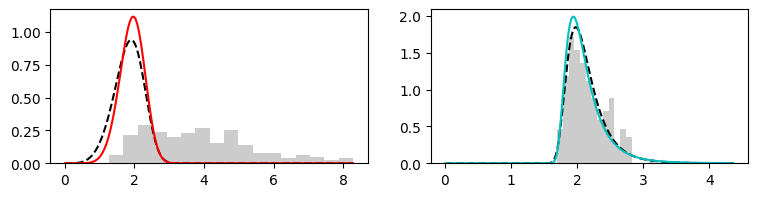

Estimated parameters:
lambda_d = 1.850409997587848,
beta_d = 0.7701932310902613,
sigma_d = 0.17117544039593602,
lambda_r = -0.9962434852987472,
beta_r = 0.6943099969592068,
sigma_r = 0.09977716694034935.


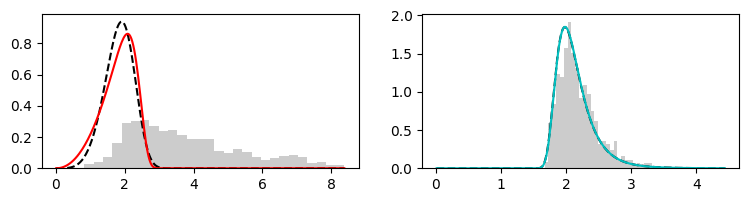

Estimated parameters:
lambda_d = 1.1052521058601776,
beta_d = 1.1158643567864548,
sigma_d = 0.19641219615016475,
lambda_r = -0.5875290553340953,
beta_r = 0.02671815954840317,
sigma_r = 0.09374037364102245.


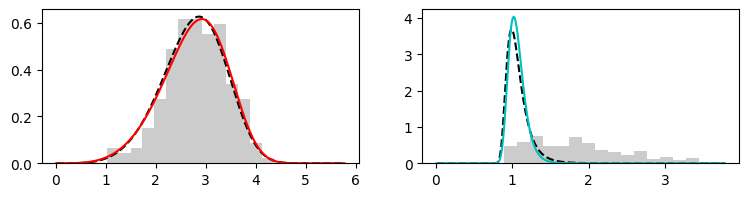

Estimated parameters:
lambda_d = 1.0757305098437602,
beta_d = 1.1078132861690198,
sigma_d = 0.18915393798353608,
lambda_r = -0.7224851206332126,
beta_r = 0.02163223787627456,
sigma_r = 0.10266983966813256.


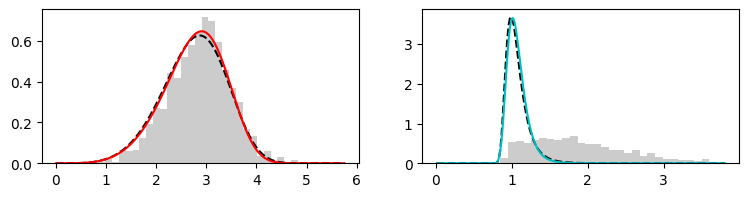

In [16]:
def test_CPM_EM(Nsample, X):
    [lamb_d, beta_d, sigma_d, lamb_r, beta_r, sigma_r] = X
    vb = stats.gamma.rvs(size = Nsample, a = 20, scale = 0.1)
    vi = stats.gamma.rvs(size = Nsample, a = 20, scale = 0.05)
    Lamb = stats.gamma.rvs(size = Nsample, a = 20, scale = 0.025)
    vd = simu_division_size_CPM(vb, vi, Lamb, X)
    
    Delta_d_app = vd - vb
    TCD = np.log(vd/(2*vi))/Lamb

    fake_data = {'Size at birth' : vb, 
                'Size at initiation per ori' : vi, 
                'Size at division' : vd, 
                'Elongation rate over C+D period' : Lamb}

    Ddplot = np.linspace(0.01, 2*np.mean(Delta_d_app), 300)
    Rplot = np.linspace(0.01, 2*np.mean(TCD), 300)

    params = []
    AICs = []
    plt.figure(figsize = (9,2))
    for loop in range(10):
        res = CPM_EM(fake_data)
        params.append(res[0])
        AICs.append(res[1])
    params = np.array(params)
    idx_min_bic = np.argmin(np.array(AICs))
    p = params[idx_min_bic]
    print('Estimated parameters:')
    print(f'lambda_d = {p[0]},')
    print(f'beta_d = {p[1]},')
    print(f'sigma_d = {p[2]},')
    print(f'lambda_r = {p[3]},')
    print(f'beta_r = {p[4]},')
    print(f'sigma_r = {p[5]}.')
    plt.subplot(121)
    histogram(Delta_d_app, 'k', 0.2)
    plt.plot(Ddplot, GenGamma_pdf(Ddplot, lamb_d, beta_d, sigma_d), 'k--')
    plt.plot(Ddplot, GenGamma_pdf(Ddplot, p[0], p[1], p[2]), 'r')
    plt.subplot(122)
    histogram(TCD, 'k', 0.2)
    plt.plot(Rplot, GenGamma_pdf(Rplot, lamb_r, beta_r, sigma_r), 'k--')
    plt.plot(Rplot, GenGamma_pdf(Rplot, p[3], p[4], p[5]), 'c')
    
lamb_d, beta_d, sigma_d = 1, np.log(2), 0.2
lamb_r, beta_r, sigma_r = -1, np.log(2), 0.1
X = [lamb_d, beta_d, sigma_d, lamb_r, beta_r, sigma_r]

np.random.seed(123)
test_CPM_EM(200, X)
plt.savefig('test_CPM_EM1_N200.pdf', format = 'pdf')
plt.show()


test_CPM_EM(1000, X)
plt.savefig('test_CPM_EM1_N1000.pdf', format = 'pdf')
plt.show()

lamb_d, beta_d, sigma_d = 1, np.log(3), 0.2
lamb_r, beta_r, sigma_r = -1, 0, 0.1
X = [lamb_d, beta_d, sigma_d, lamb_r, beta_r, sigma_r]

test_CPM_EM(200, X)
plt.savefig('test_CPM_EM2_N200.pdf', format = 'pdf')
plt.show()

test_CPM_EM(1000, X)
plt.savefig('test_CPM_EM2_N1000.pdf', format = 'pdf')
plt.show()

Parameters estimation of the CPM for every datatset:

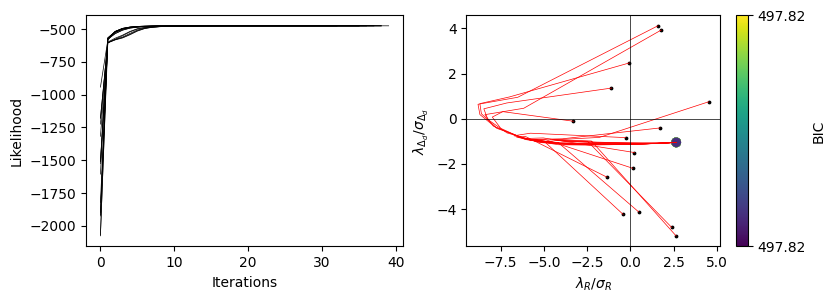

/var/folders/pv/dyn_j89n1wjbmtr1l8kdhs680000gn/T/ipykernel_54185/105238833.py:9: RuntimeWarning: invalid value encountered in log
  return stats.loggamma.logpdf(logrescaled_x, c = 1/lamb**2, scale = 1) + np.log(abs(lamb)/sigma) - np.log(x)


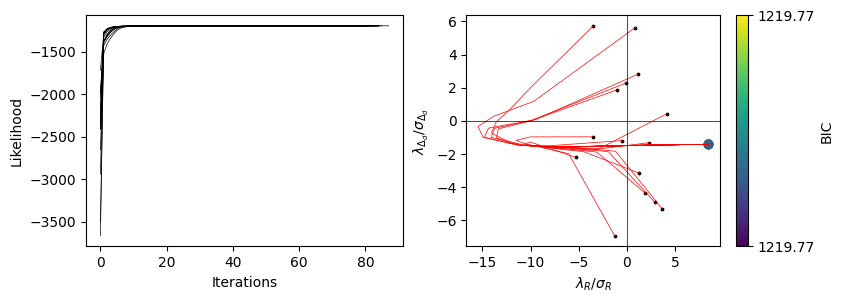

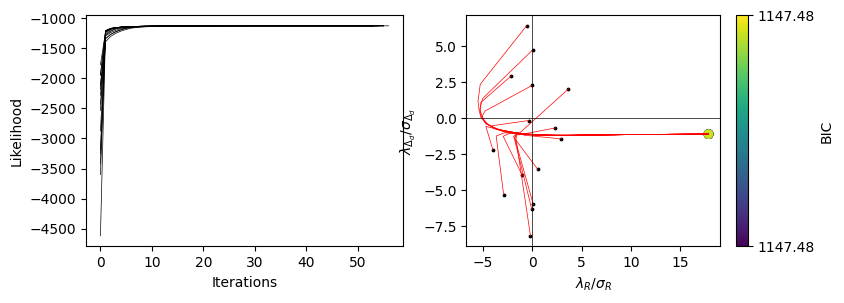

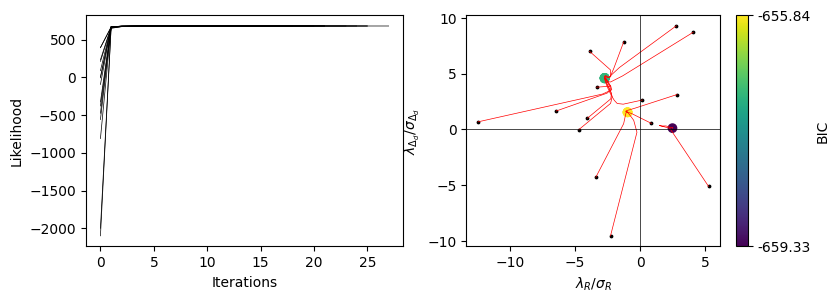

/var/folders/pv/dyn_j89n1wjbmtr1l8kdhs680000gn/T/ipykernel_54185/2363378450.py:50: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(prob_div * logf_Dd + prob_rep * logF_Dd)


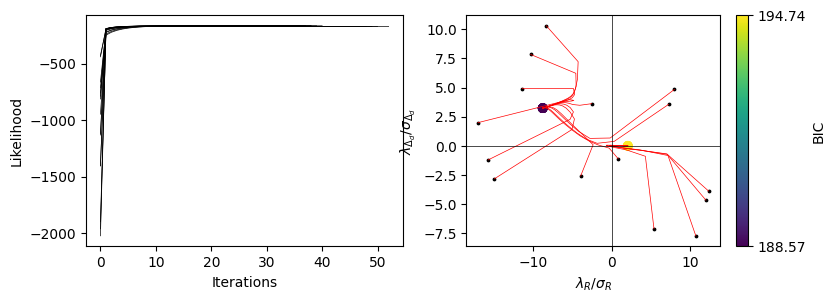

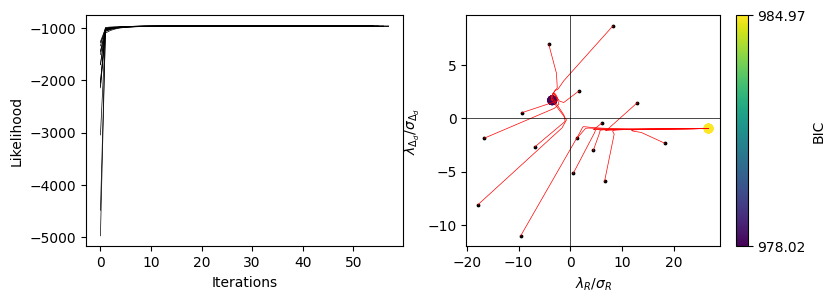

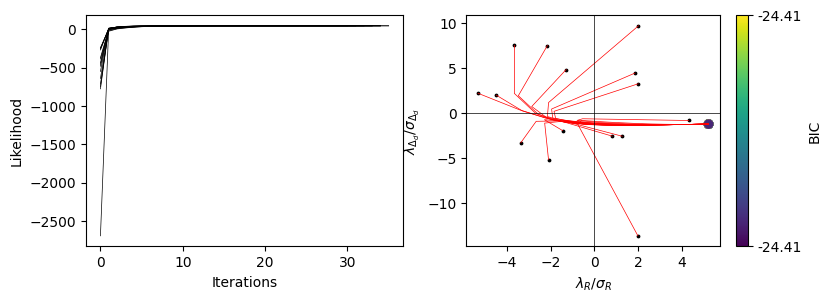

/var/folders/pv/dyn_j89n1wjbmtr1l8kdhs680000gn/T/ipykernel_54185/2363378450.py:50: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(prob_div * logf_Dd + prob_rep * logF_Dd)


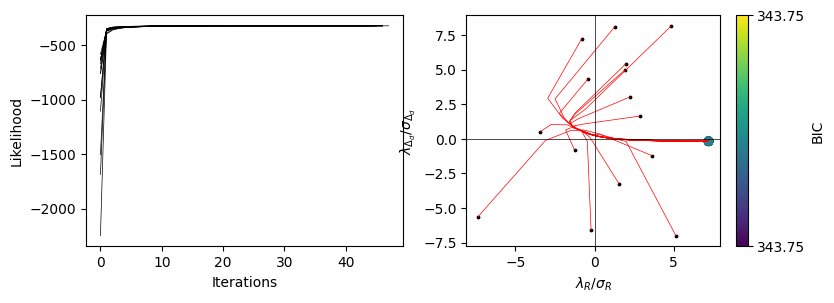

/var/folders/pv/dyn_j89n1wjbmtr1l8kdhs680000gn/T/ipykernel_54185/2363378450.py:50: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(prob_div * logf_Dd + prob_rep * logF_Dd)


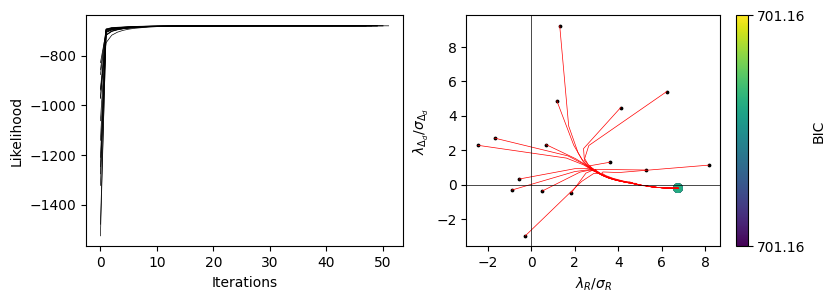

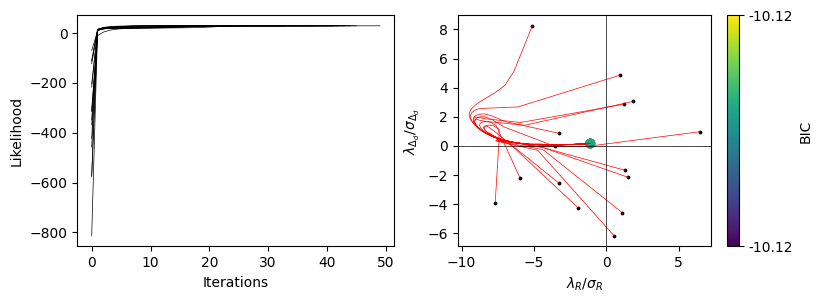

/var/folders/pv/dyn_j89n1wjbmtr1l8kdhs680000gn/T/ipykernel_54185/2363378450.py:50: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(prob_div * logf_Dd + prob_rep * logF_Dd)


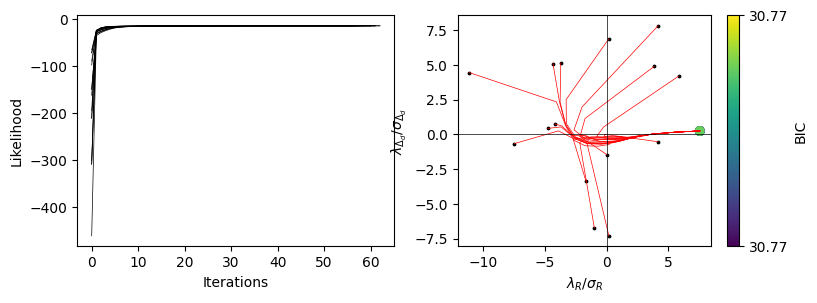

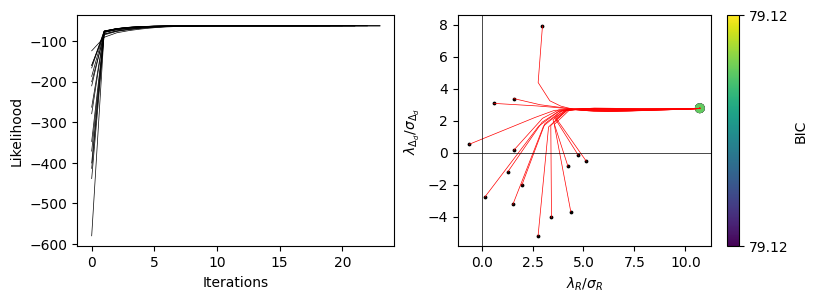

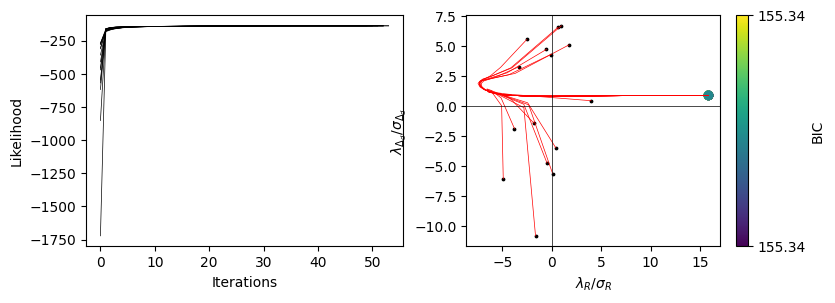

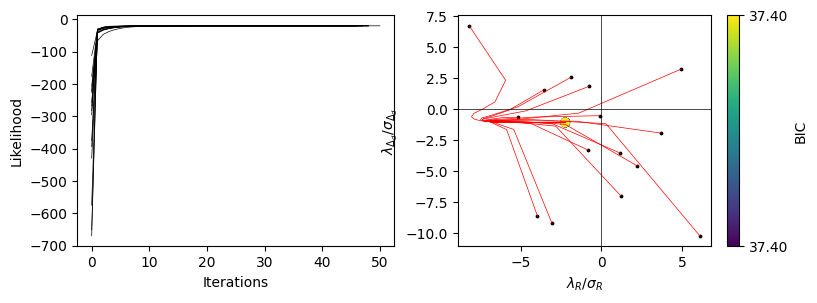

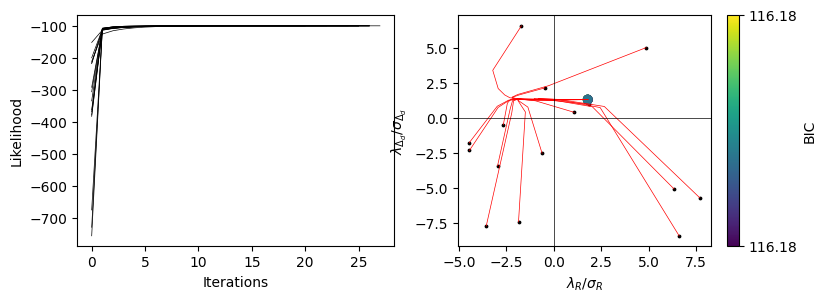

/var/folders/pv/dyn_j89n1wjbmtr1l8kdhs680000gn/T/ipykernel_54185/2363378450.py:50: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(prob_div * logf_Dd + prob_rep * logF_Dd)


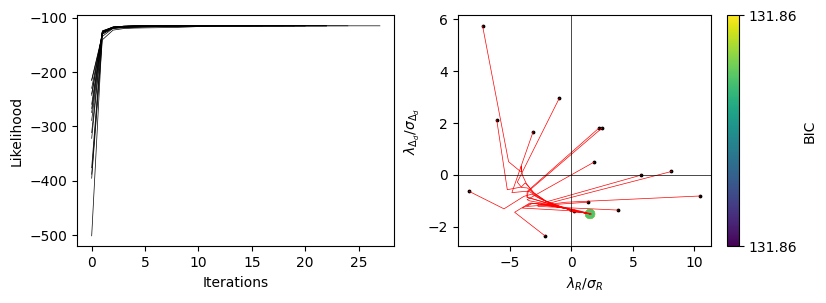

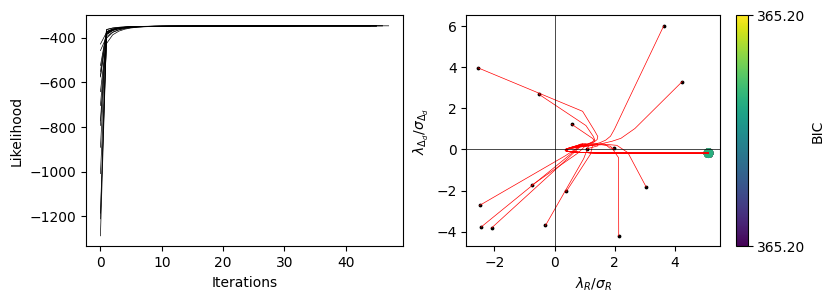

In [17]:
Results_parameters_estimation_CPM = {'parameters' : [], 'AIC' : [], 'BIC' : []}

np.random.seed(123)
for data in DATA:
    params = []
    BICs = []
    AICs = []
    plt.figure(figsize = (9,3))
    for loop in range(15):
        res = CPM_EM(data)
        params.append(res[0])
        BICs.append(res[2])
        AICs.append(res[1])
        plt.subplot(121)
        plt.plot(range(len(res[-1])), res[-1], 'k', linewidth = 0.5)
        plt.subplot(122)
        plt.plot(res[-2], res[-3], 'r', linewidth = 0.5)
        plt.scatter(res[-2][0], res[-3][0], c = 'k', s = 3)
            
    params = np.array(params)
    plt.subplot(121)
    plt.ylabel('Likelihood')
    plt.xlabel('Iterations')
    plt.subplot(122)
    plt.scatter(params[:,3]/params[:,5], params[:,0]/params[:,2], c = BICs)
    cbar = plt.colorbar(ticks=[min(BICs), max(BICs)], label ='BIC')
    cbar.ax.set_yticklabels([f'{min(BICs):.2f}', f'{max(BICs):.2f}'])
    plt.axvline(x=0, c = 'k', linewidth = 0.5)
    plt.axhline(y=0, c = 'k', linewidth = 0.5)
    plt.ylabel('$\lambda_{\Delta_d} /\sigma_{\Delta_d}$')
    plt.xlabel('$\lambda_{R} /\sigma_{R}$')
    plt.show()
    
    idx_min_bic = np.argmin(np.array(BICs))
    Results_parameters_estimation_CPM['parameters'].append(params[idx_min_bic])
    Results_parameters_estimation_CPM['AIC'].append(AICs[idx_min_bic])
    Results_parameters_estimation_CPM['BIC'].append(BICs[idx_min_bic])
    plt.show()

### Parameters estimation and BIC/AIC computation for the CAM

Similarly to the CPM, the likelihood of the CAM can be difficult to maximize, and thus we propose an Expectation-Maximization (EM) algorithm for the parameters estimation of the CAM:

In [18]:
def CAM_EM(data):
    Delta_d_app = data['Size at division'] - data['Size at birth']
    Delta_id_app = data['Size at division']/2. - data['Size at initiation per ori']
    
    def f_DIV(X):
        [lamb_d, beta_d, sigma_d, lamb_id, beta_id, sigma_id] = X
        f_Dd = GenGamma_pdf(Delta_d_app, lamb_d, beta_d, sigma_d)
        F_Did = GenGamma_cdf(Delta_id_app, lamb_id, beta_id, sigma_id)
        return f_Dd*F_Did

    def f_REP(X):
        [lamb_d, beta_d, sigma_d, lamb_id, beta_id, sigma_id] = X
        F_Dd = GenGamma_cdf(Delta_d_app, lamb_d, beta_d, sigma_d)
        f_Did = GenGamma_pdf(Delta_id_app, lamb_id, beta_id, sigma_id)
        return F_Dd*f_Did/2.
    

    # Initialization
    lamb_d, beta_d, sigma_d = init_GenGamma_fit(Delta_d_app)
    lamb_id, beta_id, sigma_id = init_GenGamma_fit(Delta_id_app)

    X = [lamb_d, beta_d, sigma_d, lamb_id, beta_id, sigma_id]
    old_X = X
    old_lklh = np.sum(np.log(f_DIV(X) + f_REP(X)))
    eps = 1
    delta_lklh = 1
    
    Lklh = [old_lklh]
    Cd = [lamb_d/sigma_d]
    Cid = [lamb_id/sigma_id]
    
    cpt = 0
    
    
    while (delta_lklh > 1e-4)&(cpt < 100)&(eps > 1e-4):
        cpt += 1
        
        #Expectation
        prob_div = f_DIV(X) / (f_DIV(X) + f_REP(X))
        prob_rep = 1 - prob_div        
        
        #Maximization
        def QDIV(XDd):
            [lamb_d, beta_d, sigma_d] = XDd
            logf_Dd = GenGamma_logpdf(Delta_d_app, lamb_d, beta_d, sigma_d)
            logF_Dd = GenGamma_logcdf(Delta_d_app, lamb_d, beta_d, sigma_d)
            if np.isnan(np.min(logf_Dd)) or np.isnan(np.min(logF_Dd)):
                return np.inf
            else:
                return -np.sum(prob_div * logf_Dd + prob_rep * logF_Dd)
        
        [lamb_d, beta_d, sigma_d] = GenGamma_minimize(QDIV, [lamb_d, beta_d, sigma_d])
        
        def QREP(XDid):
            [lamb_id, beta_id, sigma_id] = XDid
            logf_Did = GenGamma_logpdf(Delta_id_app, lamb_id, beta_id, sigma_id)
            logF_Did = GenGamma_logcdf(Delta_id_app, lamb_id, beta_id, sigma_id)
            if np.isnan(np.min(logf_Did)) or np.isnan(np.min(logF_Did)):
                return np.inf
            else:
                return -np.sum(prob_div * logF_Did + prob_rep * logf_Did)
        
        [lamb_id, beta_id, sigma_id] = GenGamma_minimize(QREP, [lamb_id, beta_id, sigma_id])
        
        X = [lamb_d, beta_d, sigma_d, lamb_id, beta_id, sigma_id]
        lklh = np.sum(np.log(f_DIV(X) + f_REP(X)))
        eps = np.sqrt(np.sum((np.array(X) - np.array(old_X))**2))
        delta_lklh = abs(old_lklh - lklh)
        old_X = X
        old_lklh = lklh
        Lklh.append(old_lklh)
        Cd.append(lamb_d/sigma_d)
        Cid.append(lamb_id/sigma_id)
    
    BIC = -lklh + 3.*np.log(np.size(Delta_d_app))
    AIC = -lklh + 6.
    return [X, AIC, BIC, Cd, Cid, Lklh]

Test of the EM algorithm for parameters estimation of the CAM:

Estimated parameters:
lambda_d = -1.087772286757608,
beta_d = 1.0013300997489616,
sigma_d = 0.30001454871611066,
lambda_id = -0.8814385072515247,
beta_id = 0.6975383506089119,
sigma_id = 0.18497842644582307.


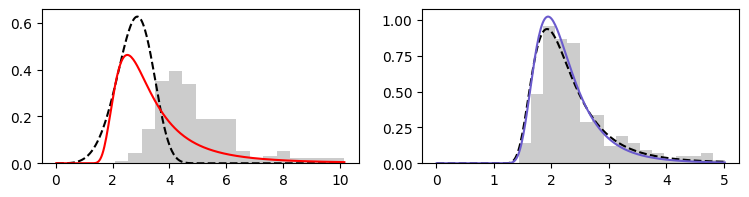

Estimated parameters:
lambda_d = -0.914827290695212,
beta_d = 0.9747538313309845,
sigma_d = 0.22463589070517895,
lambda_id = -1.0508962004377085,
beta_id = 0.6617574156865814,
sigma_id = 0.17790034656725118.


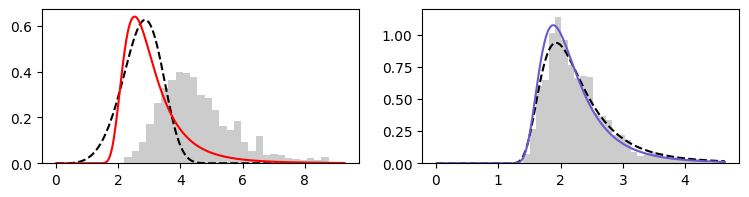

Estimated parameters:
lambda_d = 1.1676135102581562,
beta_d = 1.1277167965144432,
sigma_d = 0.18034485999260313,
lambda_id = -1.066149389830922,
beta_id = 0.006740666294378667,
sigma_id = 0.20702360809158848.


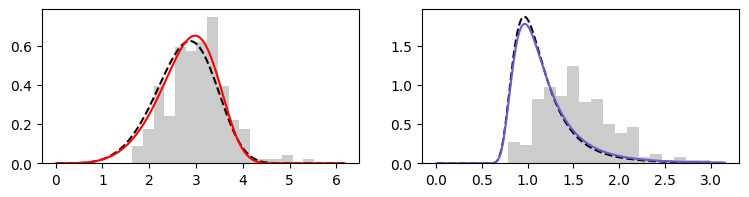

Estimated parameters:
lambda_d = 1.387442611040958,
beta_d = 1.1258471786565458,
sigma_d = 0.19156063837485687,
lambda_id = -0.9672469697140027,
beta_id = 0.0007271182702167453,
sigma_id = 0.20942895201952916.


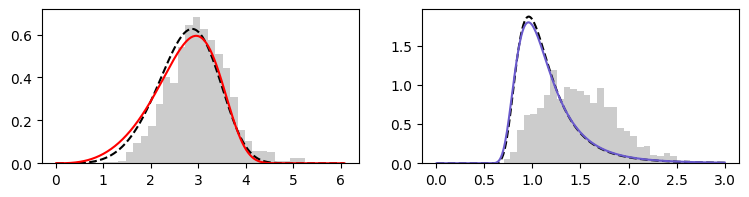

In [19]:
def test_CAM_EM(Nsample, X):
    [lamb_d, beta_d, sigma_d, lamb_id, beta_id, sigma_id] = X
    vb = stats.gamma.rvs(size = Nsample, a = 20, scale = 0.1)
    vi = stats.gamma.rvs(size = Nsample, a = 20, scale = 0.05)
    vd = simu_division_size_CAM(vb, vi, X)

    fake_data = {'Size at birth' : vb, 
                'Size at initiation per ori' : vi, 
                'Size at division' : vd}
    
    Delta_d_app = vd - vb
    Delta_id_app = vd/2. - vi

    Ddplot = np.linspace(0.01, 2*np.mean(Delta_d_app), 300)
    Didplot = np.linspace(0.01, 2*np.mean(Delta_id_app), 300)

    params = []
    AICs = []
    plt.figure(figsize = (9,2))
    for loop in range(15):
        res = CAM_EM(fake_data)
        params.append(res[0])
        AICs.append(res[1])
    params = np.array(params)
    idx_min_bic = np.argmin(np.array(AICs))
    p = params[idx_min_bic]
    print('Estimated parameters:')
    print(f'lambda_d = {p[0]},')
    print(f'beta_d = {p[1]},')
    print(f'sigma_d = {p[2]},')
    print(f'lambda_id = {p[3]},')
    print(f'beta_id = {p[4]},')
    print(f'sigma_id = {p[5]}.')
    plt.subplot(121)
    histogram(Delta_d_app, 'k', 0.2)
    plt.plot(Ddplot, GenGamma_pdf(Ddplot, lamb_d, beta_d, sigma_d), 'k--')
    plt.plot(Ddplot, GenGamma_pdf(Ddplot, p[0], p[1], p[2]), 'r')
    plt.subplot(122)
    histogram(Delta_id_app, 'k', 0.2)
    plt.plot(Didplot, GenGamma_pdf(Didplot, lamb_id, beta_id, sigma_id), 'k--')
    plt.plot(Didplot, GenGamma_pdf(Didplot, p[3], p[4], p[5]), 'slateblue')

    
lamb_d, beta_d, sigma_d = 1, np.log(3), 0.2
lamb_id, beta_id, sigma_id = -1, np.log(2), 0.2
X = [lamb_d, beta_d, sigma_d, lamb_id, beta_id, sigma_id]

np.random.seed(123)
test_CAM_EM(200, X)
plt.savefig('test_CAM_EM1_N200.pdf', format = 'pdf')
plt.show()


test_CAM_EM(1000, X)
plt.savefig('test_CAM_EM1_N1000.pdf', format = 'pdf')
plt.show()

lamb_d, beta_d, sigma_d = 1, np.log(3), 0.2
lamb_id, beta_id, sigma_id = -1, 0, 0.2
X = [lamb_d, beta_d, sigma_d, lamb_id, beta_id, sigma_id]

test_CAM_EM(200, X)
plt.savefig('test_CAM_EM2_N200.pdf', format = 'pdf')
plt.show()

test_CAM_EM(1000, X)
plt.savefig('test_CAM_EM2_N1000.pdf', format = 'pdf')
plt.show()

Parameters estimation of the CAM:

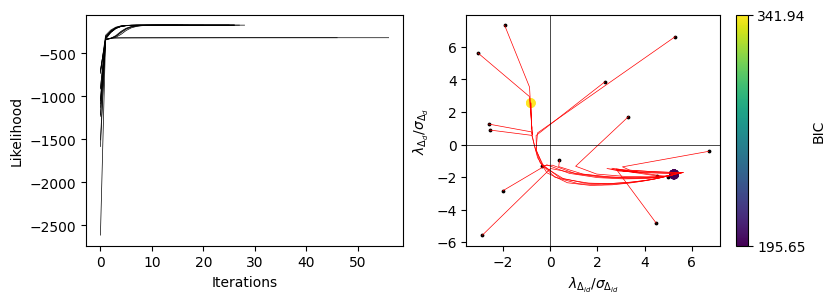

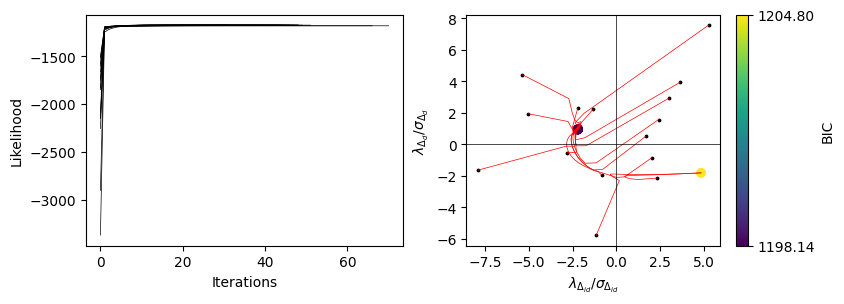

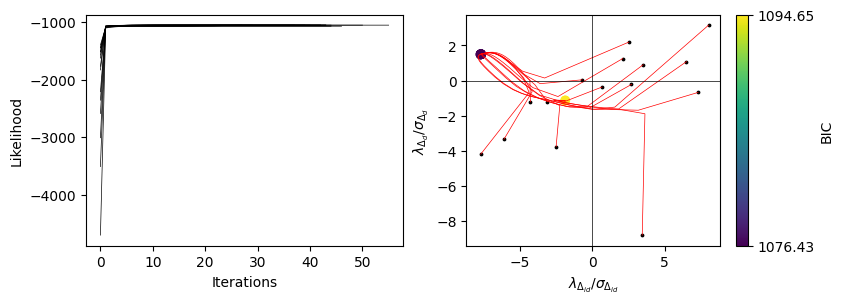

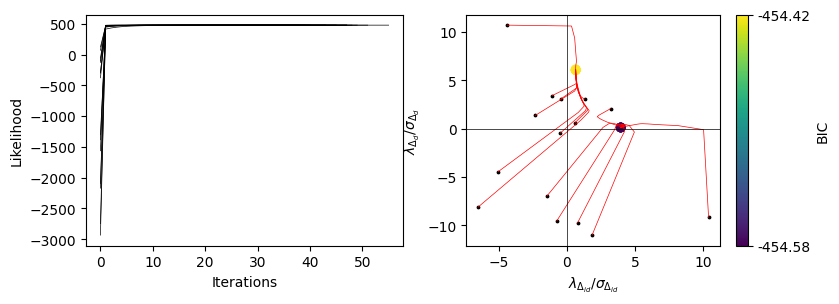

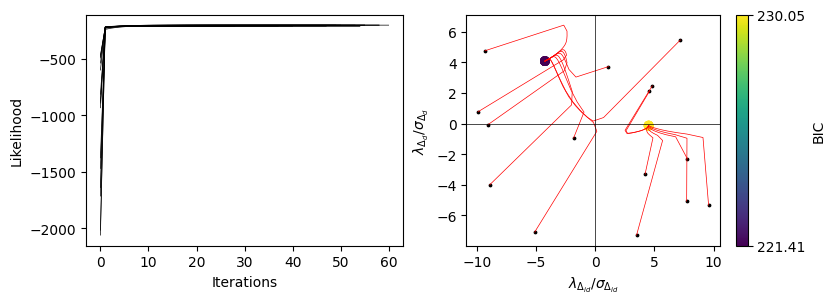

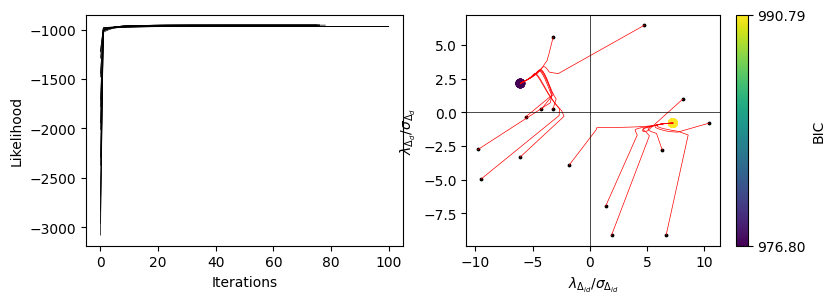

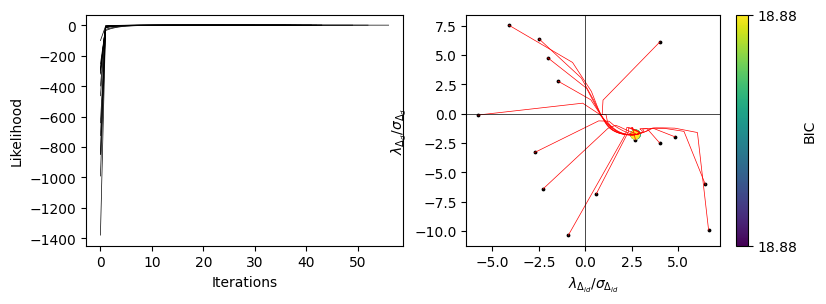

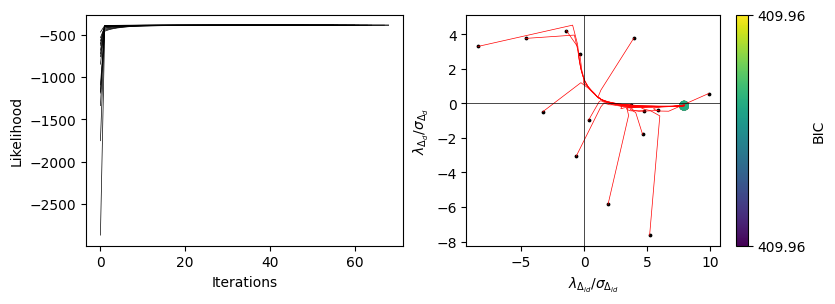

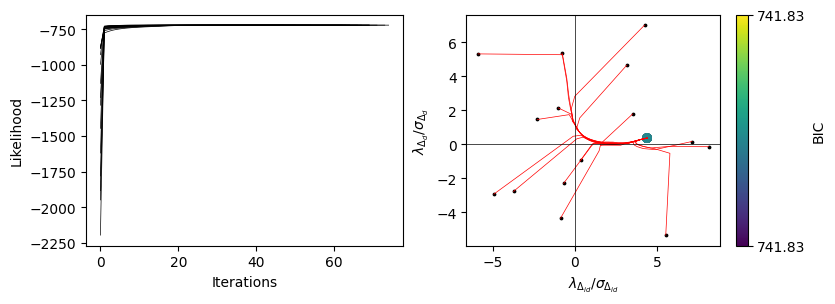

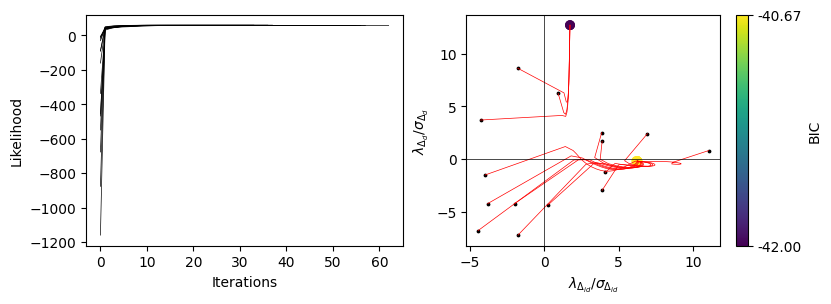

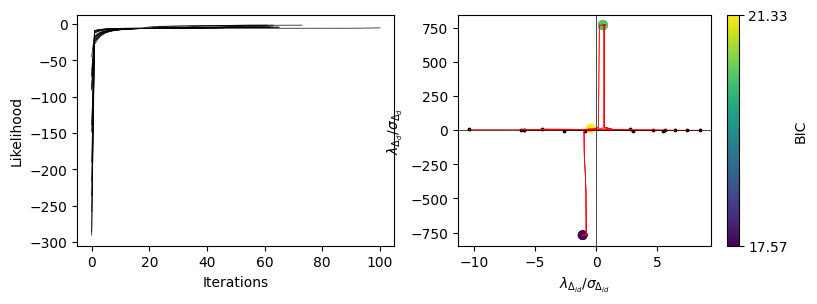

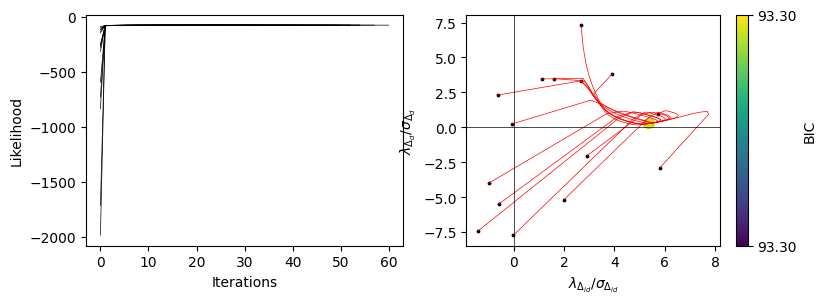

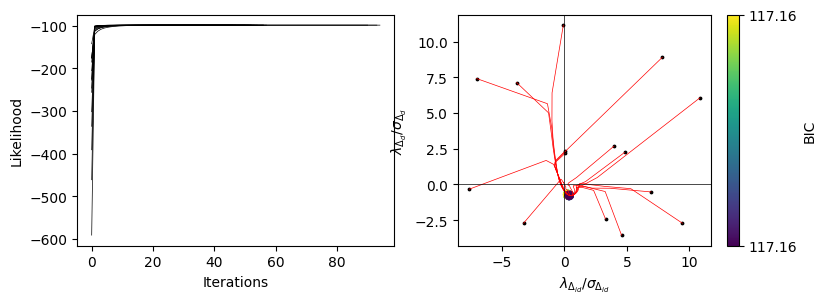

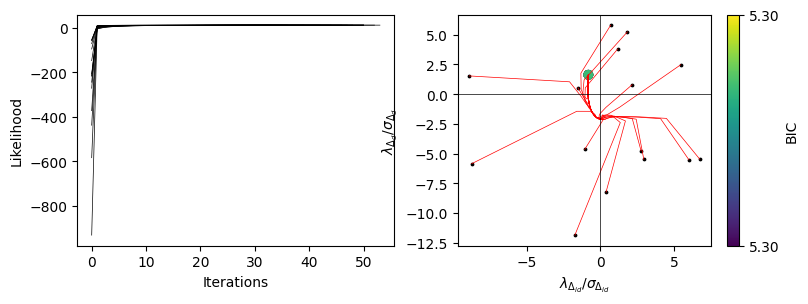

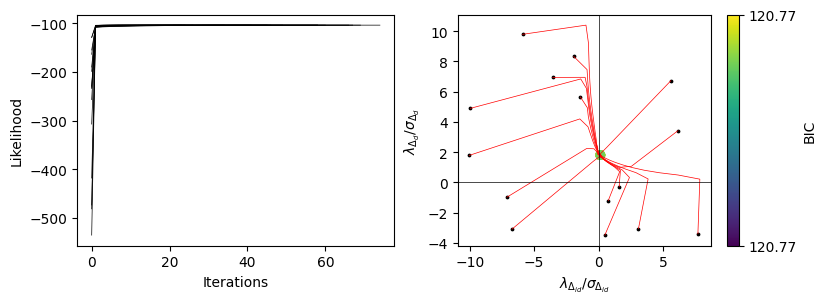

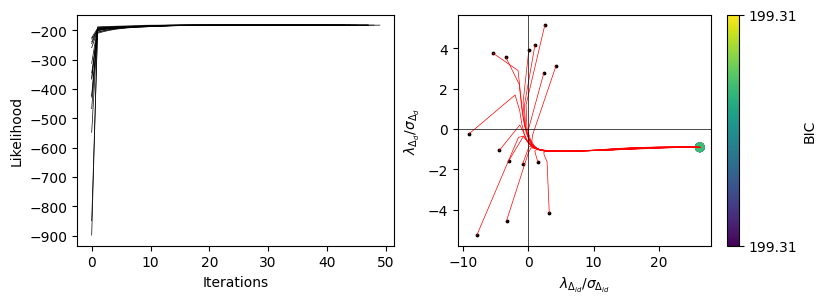

/var/folders/pv/dyn_j89n1wjbmtr1l8kdhs680000gn/T/ipykernel_54185/3485815475.py:50: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(prob_div * logf_Dd + prob_rep * logF_Dd)


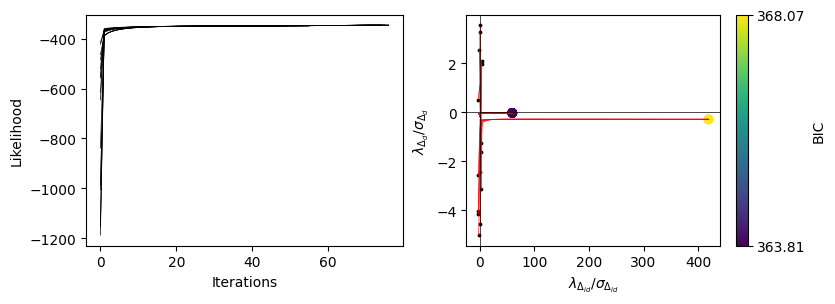

In [20]:
Results_parameters_estimation_CAM = {'parameters' : [], 'AIC' : [], 'BIC' : []}

np.random.seed(123)
for data in DATA:
    params = []
    BICs = []
    AICs = []
    plt.figure(figsize = (9,3))
    for loop in range(15):
        res = CAM_EM(data)
        params.append(res[0])
        BICs.append(res[2])
        AICs.append(res[1])
        plt.subplot(121)
        plt.plot(range(len(res[-1])), res[-1], 'k', linewidth = 0.5)
        plt.subplot(122)
        plt.plot(res[-2], res[-3], 'r', linewidth = 0.5)
        plt.scatter(res[-2][0], res[-3][0], c = 'k', s = 3)
            
    params = np.array(params)
    plt.subplot(121)
    plt.ylabel('Likelihood')
    plt.xlabel('Iterations')
    plt.subplot(122)
    plt.scatter(params[:,3]/params[:,5], params[:,0]/params[:,2], c = BICs)
    cbar = plt.colorbar(ticks=[min(BICs), max(BICs)], label ='BIC')
    cbar.ax.set_yticklabels([f'{min(BICs):.2f}', f'{max(BICs):.2f}'])
    plt.axvline(x=0, c = 'k', linewidth = 0.5)
    plt.axhline(y=0, c = 'k', linewidth = 0.5)
    plt.ylabel('$\lambda_{\Delta_d} /\sigma_{\Delta_d}$')
    plt.xlabel('$\lambda_{\Delta_{id}} /\sigma_{\Delta_{id}}$')
    plt.show()
    
    idx_min_bic = np.argmin(np.array(BICs))
    Results_parameters_estimation_CAM['parameters'].append(params[idx_min_bic])        
    Results_parameters_estimation_CAM['AIC'].append(AICs[idx_min_bic])
    Results_parameters_estimation_CAM['BIC'].append(BICs[idx_min_bic])
        

## 5. Results of the parameters estimation

### Comparsion of theoretical marginal distribution with empirical distribution of $V_b^{(\bullet +1)}$ 

In order to evaluate the quality of the parameters' estimation, one can compare the empirical distribution of size at division (halved) with 
$$f_{V_b^{(\bullet+1)}}(v) = \int p_{\theta^*}(v|v', \tilde{v}', \lambda)d\mu(v', \tilde{v}', \lambda)$$ 
with $p_{\theta^*}$ the conditional distribution of the next volume at birth with the set of parameters $\theta^*$ maximizing the likelihood, and $\mu$ the experimental empirical measure of $(V_b^{(\bullet)}, \tilde{V}_i^{(\bullet)}, \lambda^{(\bullet)})$.

/var/folders/pv/dyn_j89n1wjbmtr1l8kdhs680000gn/T/ipykernel_54185/105238833.py:7: RuntimeWarning: invalid value encountered in log
  logrescaled_x = (lamb/sigma)*(np.log(x) - beta) - 2*np.log(abs(lamb))
/var/folders/pv/dyn_j89n1wjbmtr1l8kdhs680000gn/T/ipykernel_54185/105238833.py:9: RuntimeWarning: invalid value encountered in log
  return stats.loggamma.logpdf(logrescaled_x, c = 1/lamb**2, scale = 1) + np.log(abs(lamb)/sigma) - np.log(x)
/var/folders/pv/dyn_j89n1wjbmtr1l8kdhs680000gn/T/ipykernel_54185/105238833.py:20: RuntimeWarning: invalid value encountered in log
  logrescaled_x = (lamb/sigma)*(np.log(x) - beta) - 2*np.log(abs(lamb))
/var/folders/pv/dyn_j89n1wjbmtr1l8kdhs680000gn/T/ipykernel_54185/105238833.py:16: RuntimeWarning: invalid value encountered in log
  logrescaled_x = (lamb/sigma)*(np.log(x) - beta) - 2*np.log(abs(lamb))


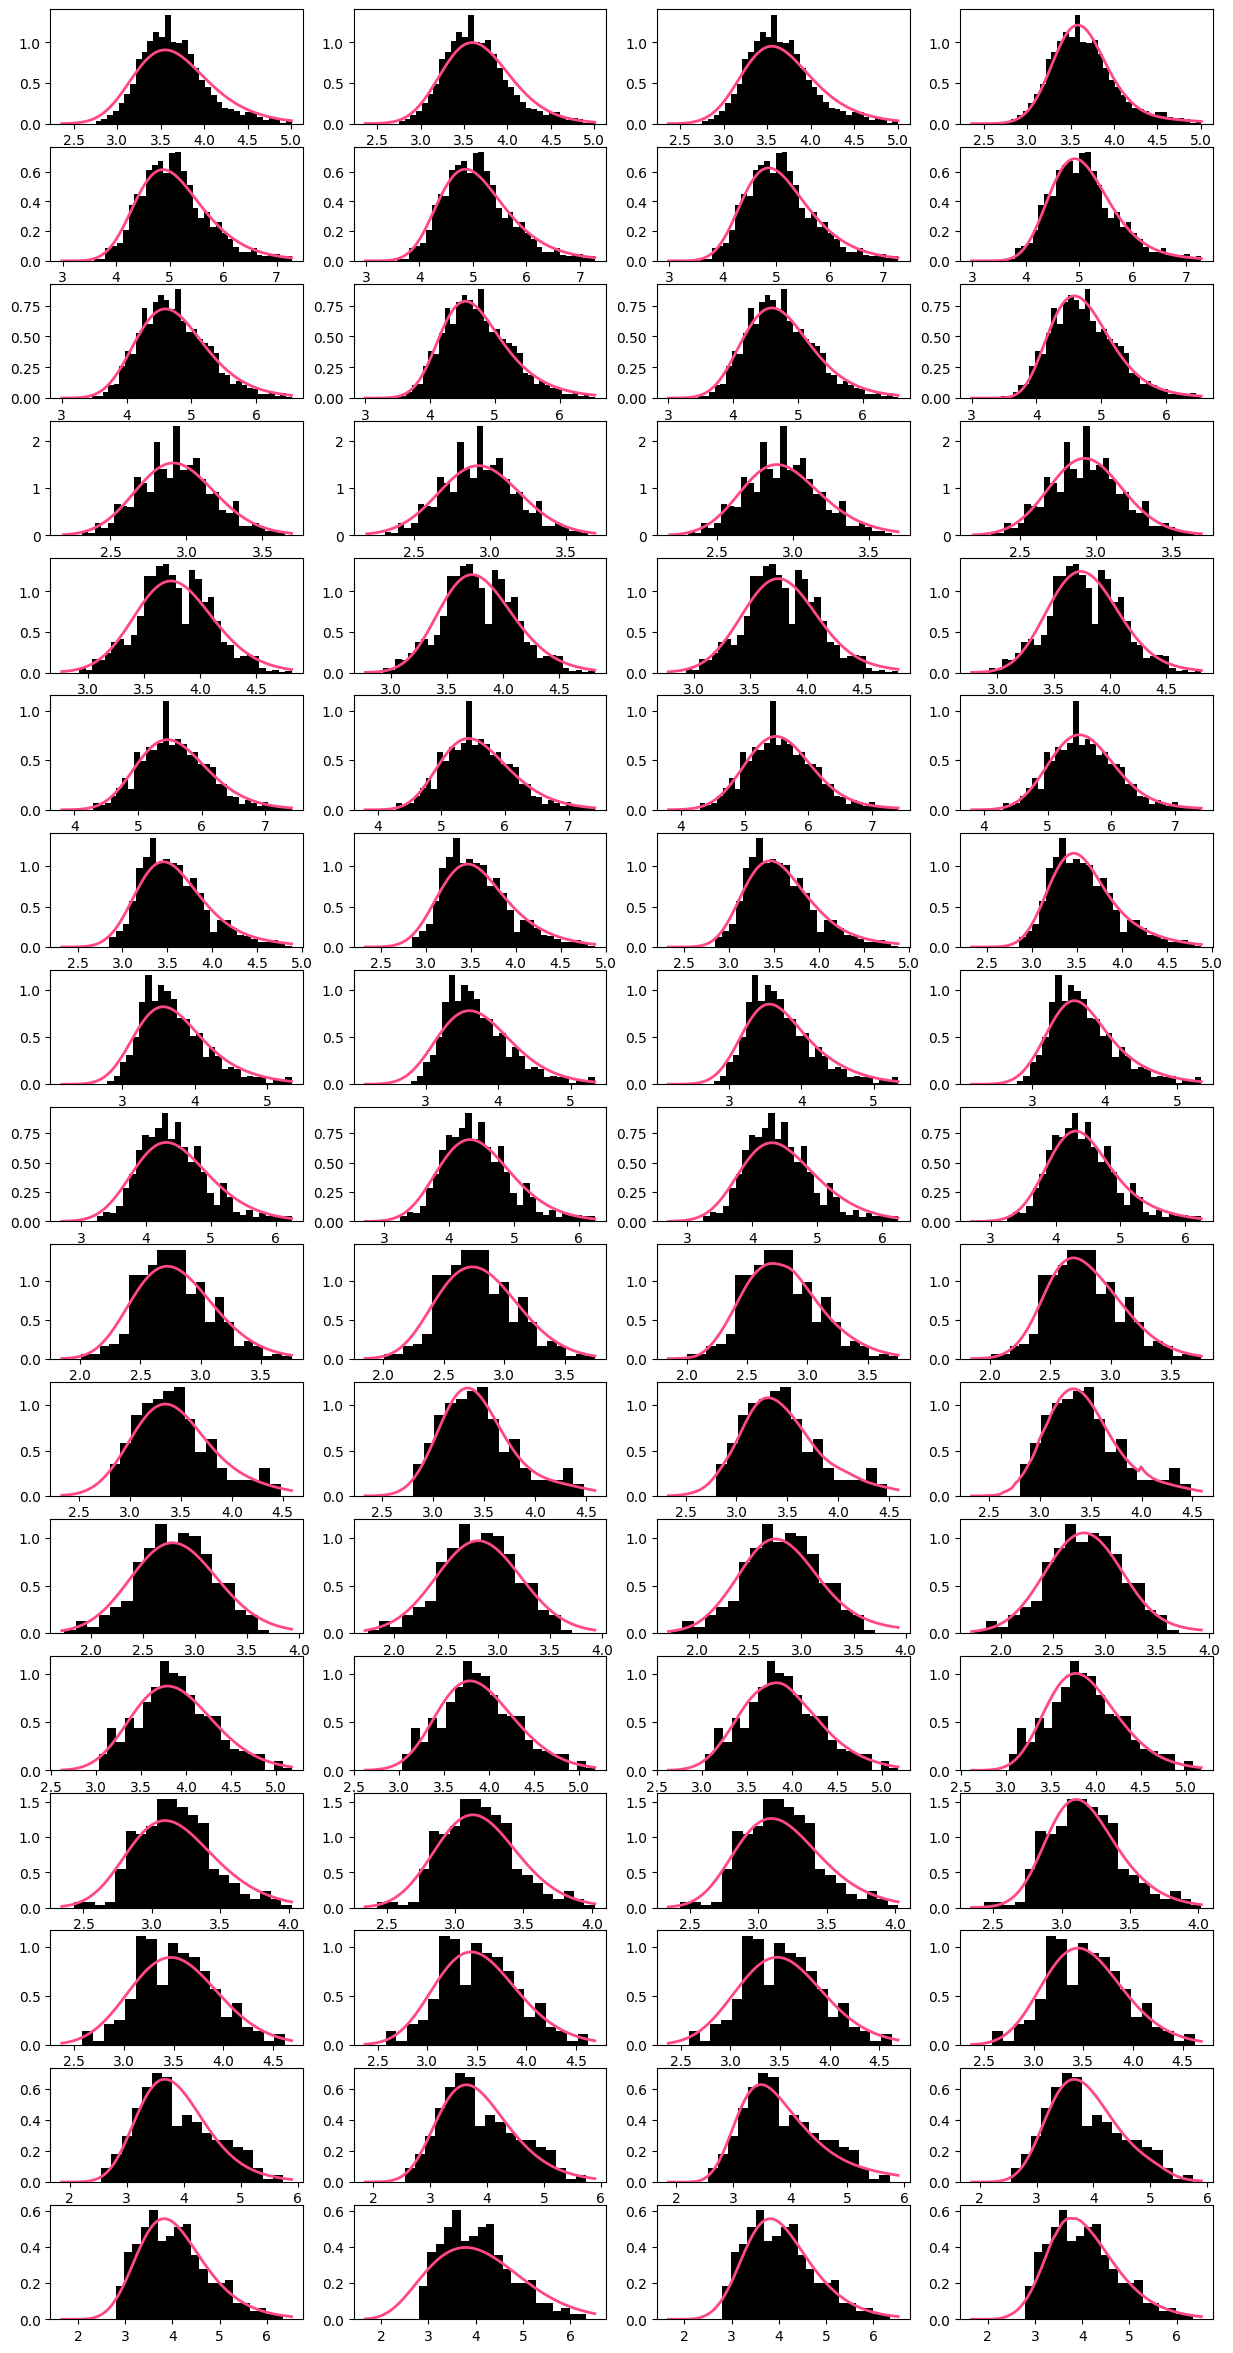

In [21]:
plt.figure(figsize = (15, 30))
k = 0
for data in DATA:
    vd = data['Size at division']
    vb = data['Size at birth']
    vi = data['Size at initiation per ori']
    Lamb = data['Elongation rate over C+D period']
        
    mean_vd = np.mean(vd)
    std_vd = np.std(vd)
    Vplot = np.linspace(mean_vd - 3*std_vd, mean_vd + 3*std_vd, 100)
        
    # DIAM
    Vd_dist = []
    [lamb, beta, sigma] = Results_parameters_estimation_DIAM['parameters'][k]
    for vplot in Vplot:
        Vd_dist.append(np.mean(GenGamma_pdf(vplot - vb, lamb, beta, sigma)))
    plt.subplot(17, 4, 4*k+1)
    histogram(vd, 'k', 1)
    plt.plot(Vplot, Vd_dist, '#FF4885', linewidth = 2)
        
    # RDAM
    Vd_dist = []
    [lamb, beta, sigma] = Results_parameters_estimation_RDAM['parameters'][k]
    for vplot in Vplot:
        Vd_dist.append(np.mean(GenGamma_pdf(vplot/2. - vi, lamb, beta, sigma)/2.))
    plt.subplot(17, 4, 4*k+2)
    histogram(vd, 'k', 1)
    plt.plot(Vplot, Vd_dist, '#FF4885', linewidth = 2)  
    
    # CPM
    Vd_dist = []
    [lamb_d, beta_d, sigma_d, lamb_r, beta_r, sigma_r] = Results_parameters_estimation_CPM['parameters'][k]
    for vplot in Vplot:
        f_Dd = GenGamma_pdf(vplot - vb, lamb_d, beta_d, sigma_d)
        F_Dd = GenGamma_cdf(vplot - vb, lamb_d, beta_d, sigma_d)
        f_R = GenGamma_pdf(np.log(vplot/(2*vi))/Lamb, lamb_r, beta_r, sigma_r)
        F_R = GenGamma_cdf(np.log(vplot/(2*vi))/Lamb, lamb_r, beta_r, sigma_r)
        Vd_dist.append(np.mean(f_Dd*F_R + F_Dd*f_R/(Lamb*vplot)))
    plt.subplot(17, 4, 4*k+3)
    histogram(vd, 'k', 1)
    plt.plot(Vplot, Vd_dist, '#FF4885', linewidth = 2)  
        
    # CAM
    Vd_dist = []        
    [lamb_d, beta_d, sigma_d, lamb_id, beta_id, sigma_id] = Results_parameters_estimation_CAM['parameters'][k]
    for vplot in Vplot:
        f_Dd = GenGamma_pdf(vplot - vb, lamb_d, beta_d, sigma_d)
        F_Dd = GenGamma_cdf(vplot - vb, lamb_d, beta_d, sigma_d)
        f_Did = GenGamma_pdf(vplot/2. - vi, lamb_id, beta_id, sigma_id)
        F_Did = GenGamma_cdf(vplot/2. - vi, lamb_id, beta_id, sigma_id)
        Vd_dist.append(np.mean(f_Dd*F_Did + F_Dd*f_Did/2.))
    plt.subplot(17, 4, 4*k+4)
    histogram(vd, 'k', 1)
    plt.plot(Vplot, Vd_dist, '#FF4885', linewidth = 2) 
    k+=1
        
plt.savefig('distribution_division_volume.pdf', format = 'pdf')

### Distribution of the latent variables of the CPM and CAM

The CPM and the CAM involve latent variables that can be compared with observable variables, depending on whether division or replication related process is limiting in the cell division.

/var/folders/pv/dyn_j89n1wjbmtr1l8kdhs680000gn/T/ipykernel_54185/105238833.py:7: RuntimeWarning: divide by zero encountered in log
  logrescaled_x = (lamb/sigma)*(np.log(x) - beta) - 2*np.log(abs(lamb))
/var/folders/pv/dyn_j89n1wjbmtr1l8kdhs680000gn/T/ipykernel_54185/105238833.py:9: RuntimeWarning: divide by zero encountered in log
  return stats.loggamma.logpdf(logrescaled_x, c = 1/lamb**2, scale = 1) + np.log(abs(lamb)/sigma) - np.log(x)


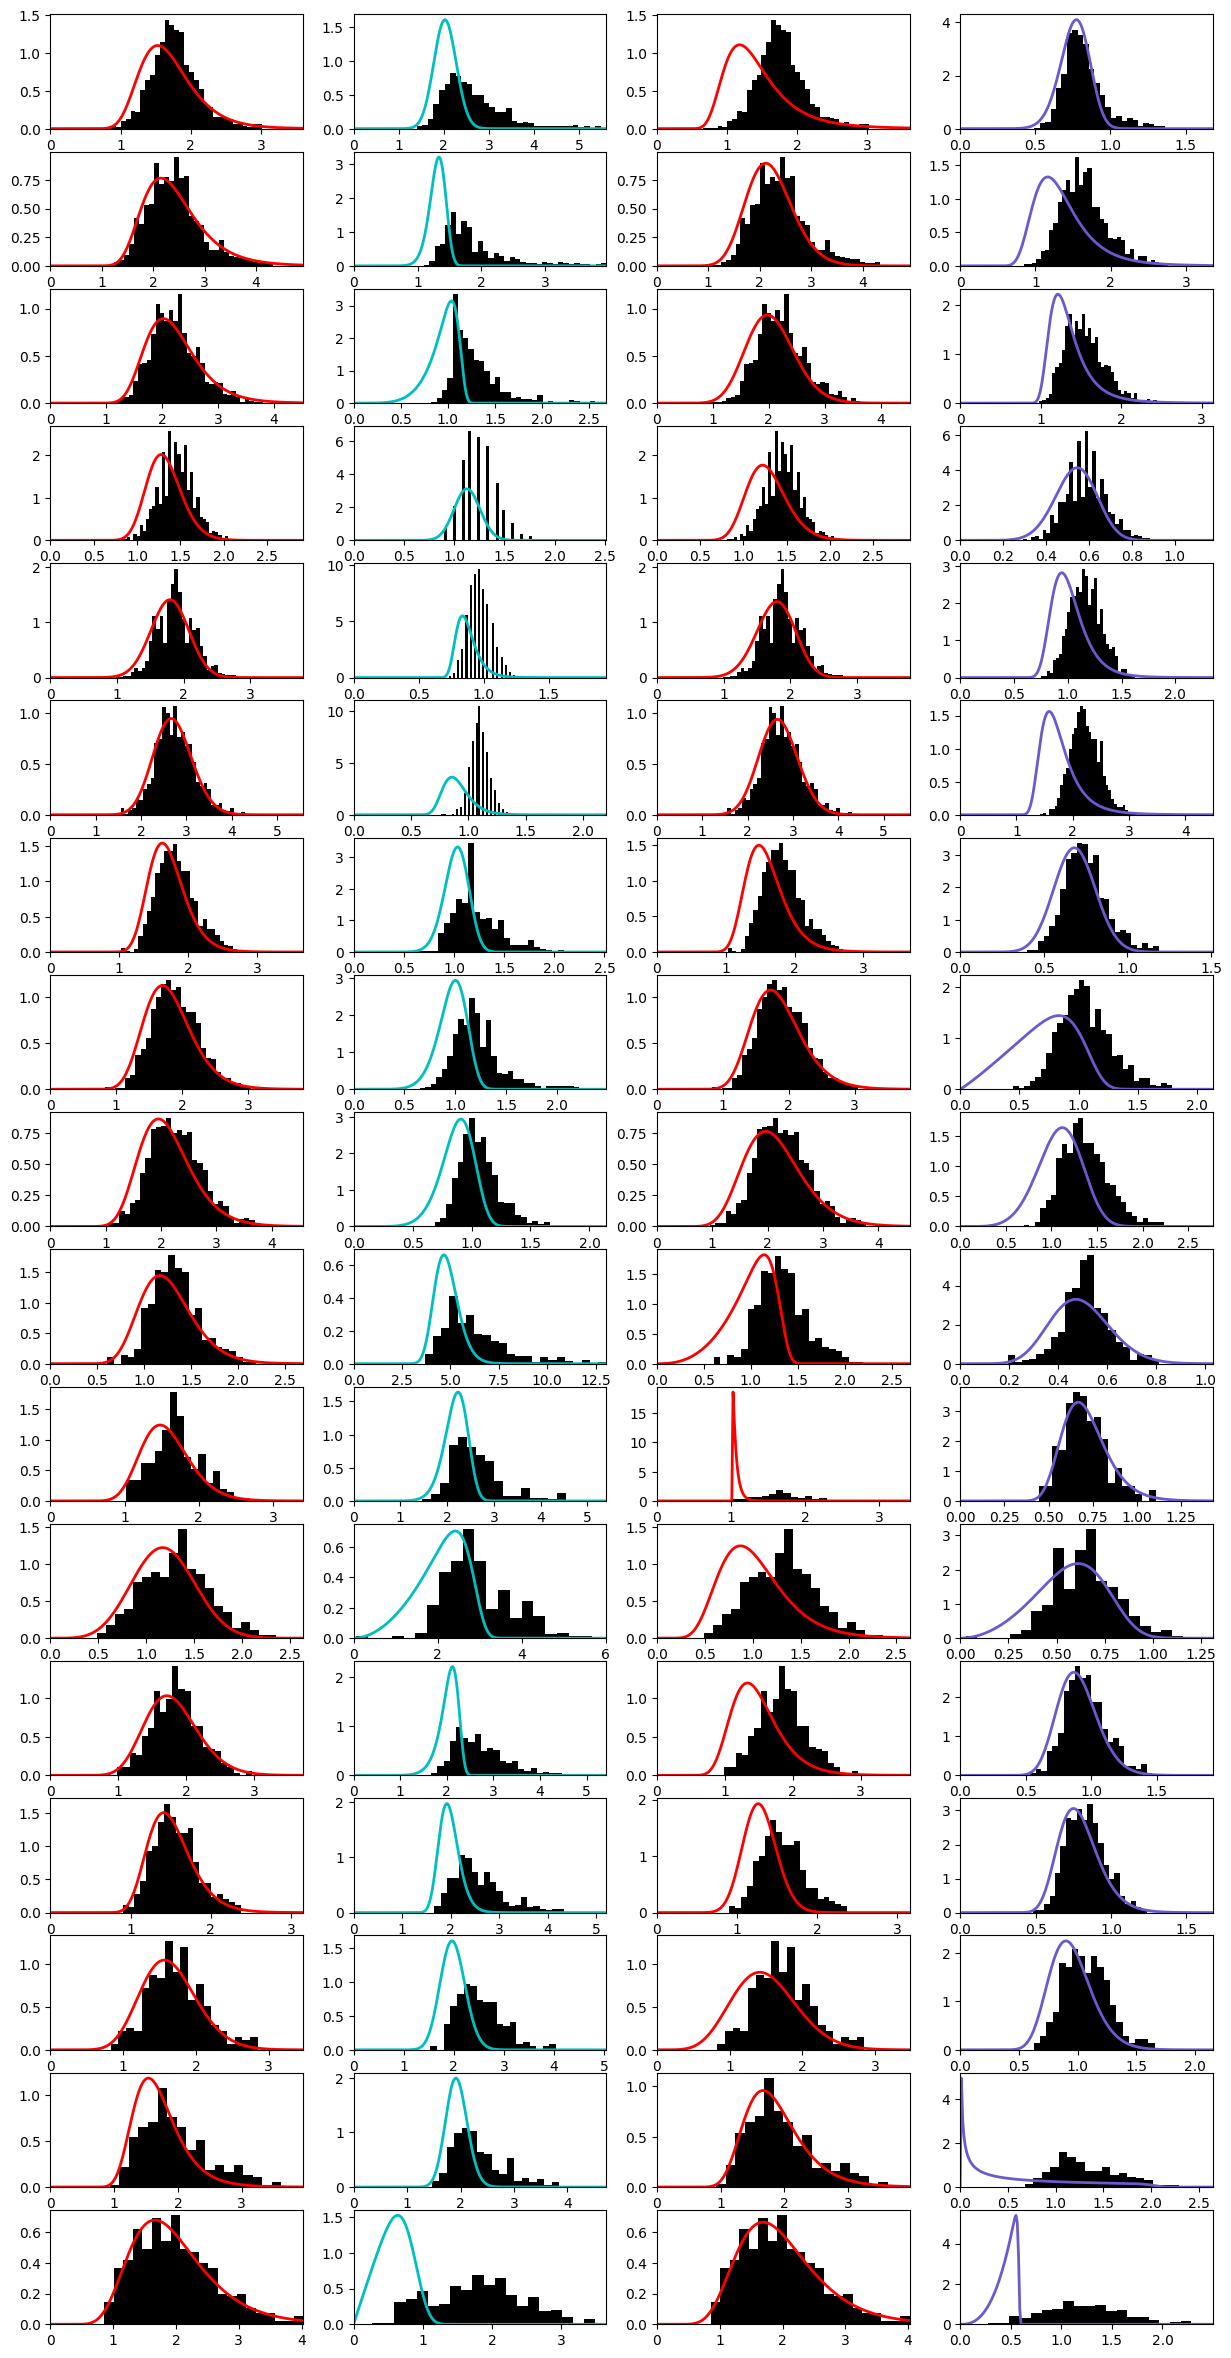

In [22]:
plt.figure(figsize = (15, 30))

k = 0
for data in DATA:
    Delta_d_app = data['Size at division'] - data['Size at birth']
    Delta_id_app = data['Size at division']/2. - data['Size at initiation per ori']
    TCD = np.log(data['Size at division']/(2*data['Size at initiation per ori']))/data['Elongation rate over C+D period']
    
    mean_Ddapp = np.mean(Delta_d_app)
    mean_Didapp = np.mean(Delta_id_app)
    mean_TCD = np.mean(TCD)
    Ddplot = np.linspace(0, 2*mean_Ddapp, 200)
    Didplot = np.linspace(0, 2*mean_Didapp, 200)
    Rplot = np.linspace(0, 2*mean_TCD, 200)
    
    [lamb_d, beta_d, sigma_d, lamb_r, beta_r, sigma_r] = Results_parameters_estimation_CPM['parameters'][k]
    
    plt.subplot(17, 4, 4*k+1)
    histogram(Delta_d_app, 'k', 1)
    plt.plot(Ddplot, GenGamma_pdf(Ddplot, lamb_d, beta_d, sigma_d), color = 'r', linewidth = 2)
    plt.xlim(0, 2*mean_Ddapp)
        
    plt.subplot(17, 4, 4*k+2)
    histogram(TCD, 'k', 1)
    plt.plot(Rplot, GenGamma_pdf(Rplot, lamb_r, beta_r, sigma_r), 'c', linewidth = 2)
    plt.xlim(0, 2*mean_TCD)
        
    [lamb_d, beta_d, sigma_d, lamb_id, beta_id, sigma_id] = Results_parameters_estimation_CAM['parameters'][k]
    
    plt.subplot(17, 4, 4*k+3)
    histogram(Delta_d_app, 'k', 1)
    plt.plot(Ddplot, GenGamma_pdf(Ddplot, lamb_d, beta_d, sigma_d), color = 'r', linewidth = 2)
    plt.xlim(0, 2*mean_Ddapp)
    
    plt.subplot(17, 4, 4*k+4)
    histogram(Delta_id_app, 'k', 1)
    plt.plot(Didplot, GenGamma_pdf(Didplot, lamb_id, beta_id, sigma_id), color = 'slateblue', linewidth = 2)  
    plt.xlim(0, 2*mean_Didapp)
    k+=1
    
plt.savefig('distribution_latent_var_CPM_CAM.pdf', format = 'pdf')

### Probability of having the replication limiting in the division, according to the CPM and the CAM

One can compute from the data and the estimated parameters of the CPM and the CAM the probability of having the replication limiting in the division process. We denote $\rho_{CPM}$ and $\rho_{CAM}$ this probabiliy according to the CPM and CAM respectively, defined as follow,

$$\rho_{CPM} := \int \mathbb{P}_{\theta^*}[\Delta_d + v_b \leq 2\tilde{v}_i \exp(\lambda R)] d \mu(v_b, \tilde{v}_i, \lambda)$$
$$\rho_{CAM} := \int \mathbb{P}_{\theta^*}[\Delta_d + v_b \leq 2(\Delta_{id} + \tilde{v}_i)] d \mu(v_b, \tilde{v}_i, \lambda)$$
with $\theta^*$ the parameters set maximizing the likelihood, and $\mu$ the experimental empirical measure of $(V_b^{(\bullet)}, \tilde{V}_i^{(\bullet)}, \lambda^{(\bullet)})$.

/var/folders/pv/dyn_j89n1wjbmtr1l8kdhs680000gn/T/ipykernel_54185/105238833.py:20: RuntimeWarning: invalid value encountered in log
  logrescaled_x = (lamb/sigma)*(np.log(x) - beta) - 2*np.log(abs(lamb))
/var/folders/pv/dyn_j89n1wjbmtr1l8kdhs680000gn/T/ipykernel_54185/105238833.py:16: RuntimeWarning: invalid value encountered in log
  logrescaled_x = (lamb/sigma)*(np.log(x) - beta) - 2*np.log(abs(lamb))
/var/folders/pv/dyn_j89n1wjbmtr1l8kdhs680000gn/T/ipykernel_54185/3878970067.py:52: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  proba_CAM.append(integrate.quad(f, 0.01, 5)[0])


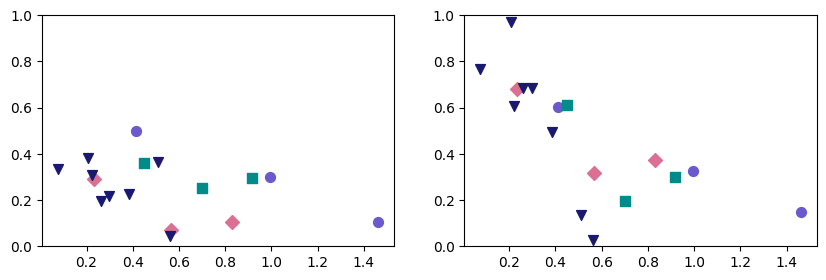

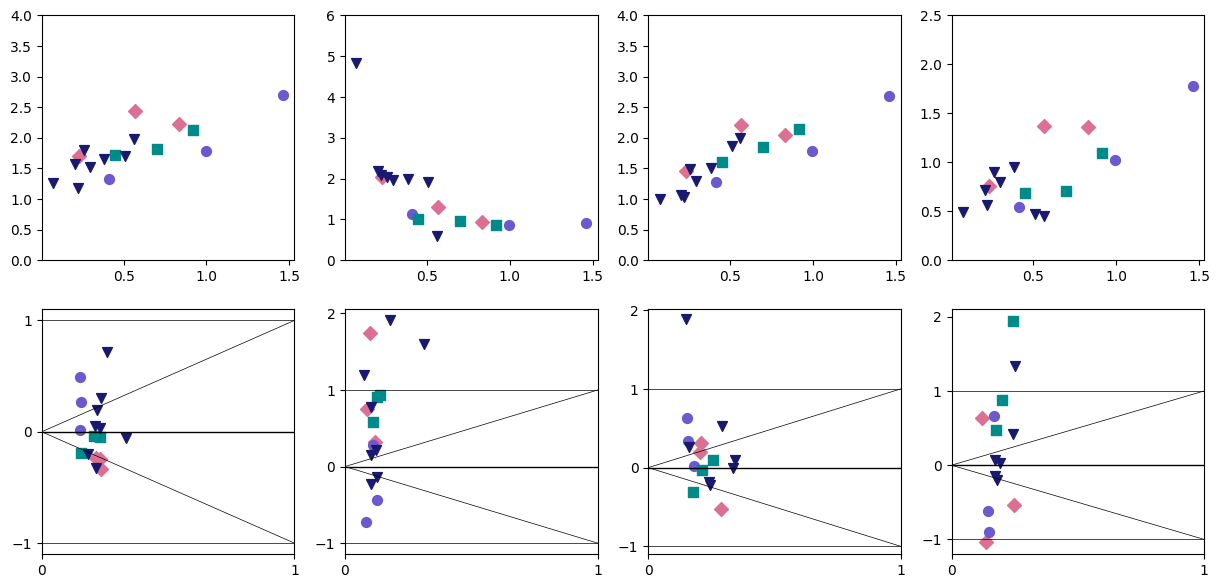

In [23]:
proba_CPM = []
mean_Delta_d_CPM = []
mean_R_CPM = []

proba_CAM = []
mean_Delta_d_CAM = []
mean_Delta_id_CAM = []


mean_lamb = []

def plot_strainwise(X,Y):
    plt.scatter(X[:3], Y[:3], marker = 'D', s = 50, color = 'palevioletred')
    plt.scatter(X[3:6], Y[3:6], marker = 'o', s = 50, color = 'slateblue')
    plt.scatter(X[6:9], Y[6:9], marker = 's', s = 50, color = 'darkcyan')
    plt.scatter(X[9:], Y[9:], marker = 'v', s = 50, color = 'midnightblue')
    
def distributions_lines():
    plt.axhline(y=0, c = 'k', linewidth = 1)
    plt.axhline(y=1, c = 'k', linewidth = 0.5)
    plt.axhline(y=-1, c = 'k', linewidth = 0.5)
    plt.axline((0, 0), slope=1, color="k", linewidth = 0.5)
    plt.axline((0, 0), slope=-1, color="k", linewidth = 0.5)
    plt.xlim(0, 1)
    plt.xticks([0,1])
    
k = 0
for data in DATA:
    vd = data['Size at division']
    vb = data['Size at birth']
    vi = data['Size at initiation per ori']
    Lamb = data['Elongation rate over C+D period']

    mean_lamb.append(np.mean(Lamb))
        
    [lamb_d, beta_d, sigma_d, lamb_r, beta_r, sigma_r] = Results_parameters_estimation_CPM['parameters'][k]
    mean_Delta_d_CPM.append(GenGamma_moments(lamb_d, beta_d, sigma_d)[0])
    mean_R_CPM.append(GenGamma_moments(lamb_r, beta_r, sigma_r)[0])
    def f(r):
        F_Dd = GenGamma_cdf(2*vi*np.exp(Lamb*r) - vb, lamb_d, beta_d, sigma_d)
        f_R = GenGamma_pdf(r, lamb_r, beta_r, sigma_r)
        return np.mean(F_Dd*f_R)
    proba_CPM.append(integrate.quad(f, 0.01, 15)[0])
        
    [lamb_d, beta_d, sigma_d, lamb_id, beta_id, sigma_id] = Results_parameters_estimation_CAM['parameters'][k]
    mean_Delta_d_CAM.append(GenGamma_moments(lamb_d, beta_d, sigma_d)[0])
    mean_Delta_id_CAM.append(GenGamma_moments(lamb_id, beta_id, sigma_id)[0])
    def f(did):
        F_Dd = GenGamma_cdf(2*(vi + did) - vb, lamb_d, beta_d, sigma_d)
        f_Did = GenGamma_pdf(did, lamb_id, beta_id, sigma_id)
        return np.mean(F_Dd*f_Did)
    proba_CAM.append(integrate.quad(f, 0.01, 5)[0])
    k+=1

plt.figure(figsize = (10, 3))

plt.subplot(121)
plot_strainwise(mean_lamb, proba_CPM)
plt.ylim(0,1)

plt.subplot(122)
plot_strainwise(mean_lamb, proba_CAM)
plt.ylim(0,1)

plt.savefig('proba_rep_limiting_CPM_CAM.pdf', format = 'pdf')

plt.figure(figsize = (15,7))

plt.subplot(241)
plot_strainwise(mean_lamb, mean_Delta_d_CPM)
plt.ylim(0,4)

plt.subplot(242)
plot_strainwise(mean_lamb, mean_R_CPM)
plt.ylim(0,6)

plt.subplot(243)
plot_strainwise(mean_lamb, mean_Delta_d_CAM)
plt.ylim(0,4)

plt.subplot(244)
plot_strainwise(mean_lamb, mean_Delta_id_CAM)
plt.ylim(0, 2.5)

P = np.array(Results_parameters_estimation_CPM['parameters'])

plt.subplot(245)
plot_strainwise(P[:,2], P[:,0])
distributions_lines()
plt.yticks([-1,0,1])

plt.subplot(246)
distributions_lines()
plot_strainwise(P[:,5], P[:,3])
plt.yticks([-1,0,1,2])

P = np.array(Results_parameters_estimation_CAM['parameters'])
plt.subplot(247)
distributions_lines()
plot_strainwise(P[:,2], P[:,0])

plt.yticks([-1,0,1,2])
plt.ylim(-1.1, 2.01)
plt.subplot(248)
distributions_lines()
plot_strainwise(P[:,5], P[:,3])
plt.yticks([-1,0,1,2])
plt.ylim(-1.2, 2.1)
plt.savefig('params_CAM.pdf', format = 'pdf')

plt.show()

### BIC scores

Here we display the BIC scores of the models for each dataset.

In [24]:
BIC = [[''] + Labels]
BIC.append(['DIAM'] + Results_parameters_estimation_DIAM['BIC'])
BIC.append(['RDAM'] + Results_parameters_estimation_RDAM['BIC'])
BIC.append(['CPM'] + Results_parameters_estimation_CPM['BIC'])
BIC.append(['CAM'] + Results_parameters_estimation_CAM['BIC'])
BIC = np.array(BIC, dtype = object).T
pd.DataFrame(data = BIC[1:,1:], index = BIC[1:,0], columns = BIC[0, 1:])

DIAM         RDAM          CPM          CAM
MG1655 acet       677.416403   445.543043    497.81621   195.645138
MG1655 gly11aa   1233.281403  1494.293427  1219.771174  1198.140539
MG1655 glu       1169.802747  1364.290082   1147.48035  1076.425565
NCM3722 arg      -253.429324  -358.506203  -659.326562  -454.582312
NCM3722 glu       269.031102   378.460234   188.572033   221.408154
NCM3722 glu12aa   989.382483  1241.541014   978.016432   976.804746
BW27378 gly       140.213801   101.205679   -24.408382     18.88008
BW27378 glu       412.904456   630.589503   343.751272   409.961553
BW27378 glu8a     766.688609   886.778557   701.162873   741.825656
BW27783 acet       54.274909   -37.541371   -10.122701   -42.004078
BW27783 alaTrE     68.098162    14.180474    30.770975    17.568431
BW27783 man       113.999075    108.89743    79.122281    93.297314
BW27783 gly       179.264413   131.057067   155.341652   117.156475
BW27783 glyTre     59.713358    31.281993    37.399797     5.303121
BW27783 glu       125.566577   123.974912    116.18458   120.771225
BW27783 glyCas    193.604843   252.144927   131.862357   199.307985
BW27783 gluCas    359.898604    471.71771   365.202423   363.805876

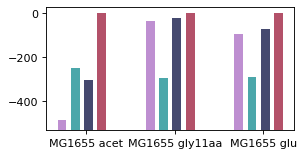

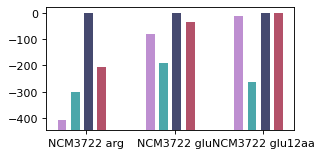

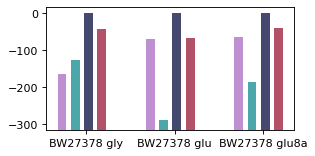

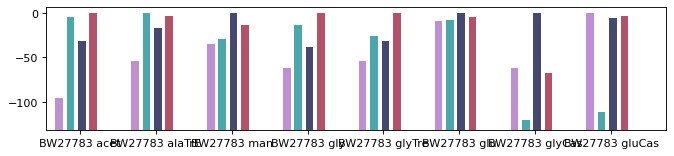

In [25]:
Min = np.min(BIC[1:,1:], axis = 1)
Delta_BIC = Min[:,None] - BIC[1:,1:]

def hist_delta_BICAIC(scores, labels):
    bottom = np.min(scores)*1.1
    n = np.shape(scores)[0]
    plt.bar(np.arange(n), scores[:,0] - bottom, width = 0.1, color = '#BE8FD1', bottom = bottom)
    plt.bar(np.arange(n)+0.15, scores[:,1] - bottom, width = 0.1, color = '#4BA7AA', bottom = bottom)
    plt.bar(np.arange(n)+0.3, scores[:,2] - bottom, width = 0.1, color = '#45496F', bottom = bottom)
    plt.bar(np.arange(n)+0.45, scores[:,3] - bottom, width = 0.1, color = '#B35169', bottom = bottom)
    plt.xticks(np.arange(n)+ 0.275, labels)
    

plt.figure(figsize=(4, 2), dpi=80)
hist_delta_BICAIC(Delta_BIC[:3], Labels[:3])
plt.show()

plt.figure(figsize=(4, 2), dpi=80)
hist_delta_BICAIC(Delta_BIC[3:6], Labels[3:6])
plt.show()

plt.figure(figsize=(4, 2), dpi=80)
hist_delta_BICAIC(Delta_BIC[6:9], Labels[6:9])
plt.show()

plt.figure(figsize=(10, 2), dpi=80)
hist_delta_BICAIC(Delta_BIC[9:], Labels[9:])
plt.xlim(-0.17, 8)
plt.show()

### AIC scores

Here we display the AIC scores of the models for each dataset.

In [26]:
AIC = [[''] + Labels]
AIC.append(['DIAM'] + Results_parameters_estimation_DIAM['AIC'])
AIC.append(['RDAM'] + Results_parameters_estimation_RDAM['AIC'])
AIC.append(['CPM'] + Results_parameters_estimation_CPM['AIC'])
AIC.append(['CAM'] + Results_parameters_estimation_CAM['AIC'])
AIC = np.array(AIC, dtype = object).T
pd.DataFrame(data = AIC[1:,1:], index = AIC[1:,0], columns = AIC[0, 1:])

DIAM         RDAM          CPM          CAM
MG1655 acet       669.393521   437.520161   481.770448   179.599375
MG1655 gly11aa     1225.3206  1486.332624  1203.849567  1182.218933
MG1655 glu       1161.554442  1356.041778  1130.983741  1059.928956
NCM3722 arg      -261.587782  -366.664661  -675.643477  -470.899226
NCM3722 glu       261.130861   370.559993   172.771551   205.607672
NCM3722 glu12aa   981.449092  1233.607622   962.149649   960.937963
BW27378 gly       133.181269    94.173146   -38.473446     4.815015
BW27378 glu       405.577726   623.262773   329.097812   395.308093
BW27378 glu8a     759.200465   879.290412   686.186583   726.849367
BW27783 acet       48.283967   -43.532313   -22.104585   -53.985962
BW27783 alaTrE     63.042205     9.124517    20.659061     7.456517
BW27783 man        108.44841   103.346765     68.02095    82.195984
BW27783 gly       173.204031   124.996685   143.220888   105.035711
BW27783 glyTre     53.952396     25.52103    25.877872    -6.218804
BW27783 glu       120.231335    118.63967   105.514096   110.100741
BW27783 glyCas    188.322651   246.862736   121.297974   188.743602
BW27783 gluCas     354.03241   465.851515   353.470033   352.073486

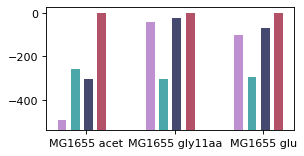

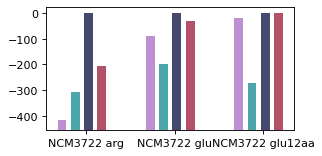

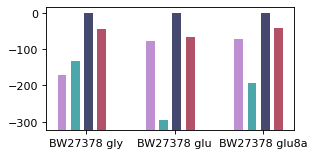

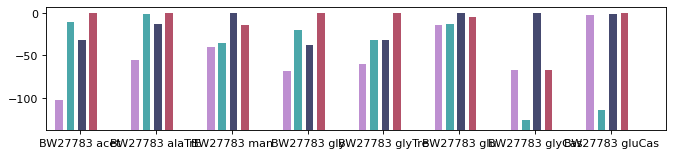

In [27]:
Min = np.min(AIC[1:,1:], axis = 1)
Delta_AIC = Min[:,None] - AIC[1:,1:]

plt.figure(figsize=(4, 2), dpi=80)
hist_delta_BICAIC(Delta_AIC[:3], Labels[:3])
plt.show()

plt.figure(figsize=(4, 2), dpi=80)
hist_delta_BICAIC(Delta_AIC[3:6], Labels[3:6])
plt.show()

plt.figure(figsize=(4, 2), dpi=80)
hist_delta_BICAIC(Delta_AIC[6:9], Labels[6:9])
plt.show()

plt.figure(figsize=(10, 2), dpi=80)
hist_delta_BICAIC(Delta_AIC[9:], Labels[9:])
plt.xlim(-0.17, 8)
plt.show()

## 6. Wasserstein distances computation

Definition of a funcion computing the empirical Wasserstein distance between 2-dimentional sets of data.

In [28]:
def wasserstein_distance(X, Y):
    n_X = np.size(X[:,0])
    n_Y = np.size(Y[:,0])
    cost_matrix = ot.dist(X, Y, metric='euclidean')
    weights_X = np.ones(n_X) / n_X
    weights_Y = np.ones(n_Y) / n_Y
    return ot.emd2(weights_X, weights_Y, cost_matrix)

In [29]:
def Wasserstein_DIAM(data, param, nb_sim):
    np.random.seed(123)
    N = np.size(data['Size at division'])
    vd = np.reshape(data['Size at division'], (N,1))
    vb = np.reshape(data['Size at birth'], (N,1))
    vi = np.reshape(data['Size at initiation per ori'], (N,1))
    Lamb = np.reshape(data['Elongation rate over C+D period'], (N,1))
    
    dist_vi = []
    dist_vb = []
    for n in range(nb_sim):
        vd_sim = vb + GenGamma_rvs(*[(N,1)] + param)
        dist_vi.append(wasserstein_distance(np.concatenate((vd_sim, vi), axis = 1), np.concatenate((vd, vi), axis = 1)))
        dist_vb.append(wasserstein_distance(np.concatenate((vd_sim, vb), axis = 1), np.concatenate((vd, vb), axis = 1)))
    return (np.array(dist_vi), np.array(dist_vb))

In [30]:
def Wasserstein_RDAM(data, param, nb_sim):
    np.random.seed(123)
    N = np.size(data['Size at division'])
    vd = np.reshape(data['Size at division'], (N,1))
    vb = np.reshape(data['Size at birth'], (N,1))
    vi = np.reshape(data['Size at initiation per ori'], (N,1))
    Lamb = np.reshape(data['Elongation rate over C+D period'], (N,1))
    
    dist_vi = []
    dist_vb = []
    for n in range(nb_sim):
        vd_sim = 2*(vi + GenGamma_rvs(*[(N,1)] + param))
        dist_vi.append(wasserstein_distance(np.concatenate((vd_sim, vi), axis = 1), np.concatenate((vd, vi), axis = 1)))
        dist_vb.append(wasserstein_distance(np.concatenate((vd_sim, vb), axis = 1), np.concatenate((vd, vb), axis = 1)))
    return (np.array(dist_vi), np.array(dist_vb))

In [31]:
def Wasserstein_CPM(data, param, nb_sim):
    np.random.seed(123)
    N = np.size(data['Size at division'])
    vd = np.reshape(data['Size at division'], (N,1))
    vb = np.reshape(data['Size at birth'], (N,1))
    vi = np.reshape(data['Size at initiation per ori'], (N,1))
    Lamb = np.reshape(data['Elongation rate over C+D period'], (N,1))
    
    dist_vi = []
    dist_vb = []
    for n in range(nb_sim):
        vd_sim = simu_division_size_CPM(vb, vi, Lamb, param)
        dist_vi.append(wasserstein_distance(np.concatenate((vd_sim, vi), axis = 1), np.concatenate((vd, vi), axis = 1)))
        dist_vb.append(wasserstein_distance(np.concatenate((vd_sim, vb), axis = 1), np.concatenate((vd, vb), axis = 1)))
    return (np.array(dist_vi), np.array(dist_vb))

In [32]:
def Wasserstein_CAM(data, param, nb_sim):
    np.random.seed(124)
    N = np.size(data['Size at division'])
    vd = np.reshape(data['Size at division'], (N,1))
    vb = np.reshape(data['Size at birth'], (N,1))
    vi = np.reshape(data['Size at initiation per ori'], (N,1))
    
    dist_vi = []
    dist_vb = []
    for n in range(nb_sim):
        vd_sim = simu_division_size_CAM(vb, vi, param)
        dist_vi.append(wasserstein_distance(np.concatenate((vd_sim, vi), axis = 1), np.concatenate((vd, vi), axis = 1)))
        dist_vb.append(wasserstein_distance(np.concatenate((vd_sim, vb), axis = 1), np.concatenate((vd, vb), axis = 1)))
    return (np.array(dist_vi), np.array(dist_vb))

In the next command we compute every Wasserstein distances. Note that this computation may take some time. 

In [33]:
Wass_dist_vb = []
Wass_dist_vi = []

k = 0
for data in DATA:
    print(k, '/17 datasets done', end='\r')
    Res_wass_DIAM = Wasserstein_DIAM(data, Results_parameters_estimation_DIAM['parameters'][k], 100)
    Res_wass_RDAM = Wasserstein_RDAM(data, Results_parameters_estimation_RDAM['parameters'][k], 100)
    Res_wass_CPM = Wasserstein_CPM(data, Results_parameters_estimation_CPM['parameters'][k], 100)
    Res_wass_CAM = Wasserstein_CAM(data, Results_parameters_estimation_CAM['parameters'][k], 100)
    Wass_dist_vb.append([Res_wass_DIAM[0], Res_wass_RDAM[0], Res_wass_CPM[0], Res_wass_CAM[0]])
    Wass_dist_vi.append([Res_wass_DIAM[1], Res_wass_RDAM[1], Res_wass_CPM[1], Res_wass_CAM[1]])
    k+=1
print('17/17 datasets done', end='\r')
Wass_dist_vb = np.array(Wass_dist_vb)
Wass_dist_vi = np.array(Wass_dist_vi)

In [34]:
def plot_Wassdist(model1, model2, covariate):
    modelnames = ['DIAM', 'RDAM', 'CPM', 'CAM']
    covariares = ['vb', 'vi']
    W = [Wass_dist_vb, Wass_dist_vi]
    color = ['#D2A6EC', '#59C9CF', '#45496F', '#DC5D71']
    i = modelnames.index(model1)
    j = modelnames.index(model2)
    m = covariares.index(covariate)
    w = W[m]
    
    mean_M1 = np.mean(w[:,i,:], axis = 1)
    errorbarM1 =  np.quantile(w[:,i,:], (0.025,0.975), axis = 1).T - mean_M1[:,None]
    plt.errorbar(np.arange(1,18)-0.15, mean_M1, yerr = np.abs(errorbarM1.T), ecolor = 'k', color = color[i], capsize=2,fmt='s', alpha = 1, markersize=7) 

    mean_M2 = np.mean(w[:,j,:], axis = 1)
    errorbarM2 =  np.quantile(w[:,j,:], (0.025,0.975), axis = 1).T - mean_M2[:,None]
    plt.errorbar(np.arange(1,18)+0.15, mean_M2, yerr = np.abs(errorbarM2.T), ecolor = 'k', color = color[j], capsize=2,fmt='s', alpha = 1, markersize=7) 
        
    plt.yscale('log')
    plt.ylim(np.min(w[:,(i,j),:])*0.9, np.max(w[:,(i,j),:])*1.5)
    plt.xticks(range(19))

    for k in range(17):
        pvalue = stats.mannwhitneyu(w[k,i,:], w[k,j,:]).pvalue
        significance_asterisk(pvalue, k+1, np.max(w[:,(i,j),:])*1.1, np.quantile(w[k,i,:], 0.975)*1.1, np.quantile(w[k,j,:], 0.975)*1.1)


### Comparison CAM and CPM in reconstructing initiation-division volumes dependence 

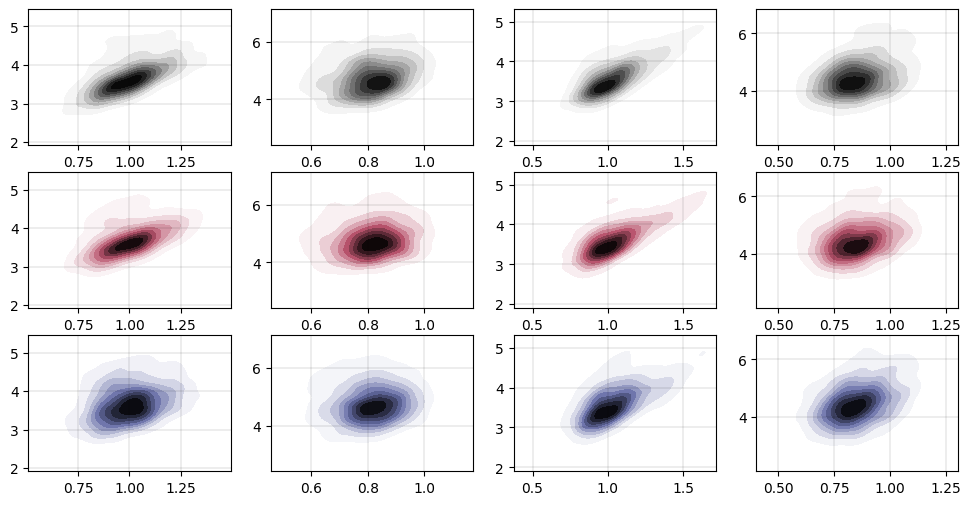

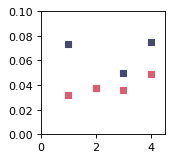

In [35]:
custom_cmap_data = LinearSegmentedColormap.from_list('name', ['w', 'k'], N=256)
custom_cmap_DIAM = LinearSegmentedColormap.from_list('name', ['w', '#896696', 'k'], N=256)
custom_cmap_RDAM = LinearSegmentedColormap.from_list('name', ['w', '#387D80', 'k'], N=256)
custom_cmap_CPM = LinearSegmentedColormap.from_list('name', ['w', '#686FA8', 'k'], N=256)
custom_cmap_CAM = LinearSegmentedColormap.from_list('name', ['w', '#B8536C', 'k'], N=256)

W_vi = []

index = [0, 2, 6, 8]
k = 0
plt.figure(figsize=(12, 6))
for data in [MG_acet, MG_glu, BW_gly, BW_glu8a]:
    np.random.seed(123)
    N = np.size(data['Size at division'])
    vd = np.reshape(data['Size at division'], (N,1))
    vb = np.reshape(data['Size at birth'], (N,1))
    vi = np.reshape(data['Size at initiation per ori'], (N,1))
    Lamb = np.reshape(data['Elongation rate over C+D period'], (N,1))
    
        
    vd_sim_CPM = simu_division_size_CPM(vb, vi, Lamb, Results_parameters_estimation_CPM['parameters'][index[k]])
    vd_sim_CAM = simu_division_size_CAM(vb, vi, Results_parameters_estimation_CAM['parameters'][index[k]])
    W_vi.append(wasserstein_distance(np.concatenate((vd_sim_CPM, vi), axis = 1), np.concatenate((vd, vi), axis = 1)))
    W_vi.append(wasserstein_distance(np.concatenate((vd_sim_CAM, vi), axis = 1), np.concatenate((vd, vi), axis = 1)))
    
        
    ylim = (np.mean(vd) - 4*np.std(vd), np.mean(vd) + 4*np.std(vd))
    xlim = (np.mean(vi) - 4*np.std(vi), np.mean(vi) + 4*np.std(vi))
        
    plt.subplot(3, 4 , k+1)
    sns.kdeplot(x=vi.flatten(), y=vd.flatten(), fill = True, cmap=custom_cmap_data)
    plt.grid(color ='k', linewidth = 0.1)
    plt.ylim(ylim)
    plt.xlim(xlim)

    plt.subplot(3, 4 , k+5)
    sns.kdeplot(x=vi.flatten(), y=vd_sim_CAM.flatten(), fill = True, cmap=custom_cmap_CAM)
    plt.grid(color ='k', linewidth = 0.1)
    plt.ylim(ylim)
    plt.xlim(xlim)

    plt.subplot(3, 4, k+9)
    sns.kdeplot(x=vi.flatten(), y=vd_sim_CPM.flatten(), fill = True, cmap=custom_cmap_CPM)
    plt.grid(color ='k', linewidth = 0.1)
    plt.ylim(ylim)
    plt.xlim(xlim)
    k+=1
        
plt.savefig('plot_emp_distrib_vi.pdf', format = 'pdf')
plt.show()

W_vi = np.array(W_vi)

plt.figure(figsize=(2, 2), dpi=80)
plt.scatter([1,2,3,4], W_vi[::2], c = '#45496F', marker = 's')
plt.scatter([1,2,3,4], W_vi[1::2], c = '#DC5D71', marker = 's')
plt.ylim(0, 0.1)
plt.xlim(0, 4.5)
plt.savefig('Wass_dist_emp_distrib_vi.pdf', format = 'pdf')
plt.show()

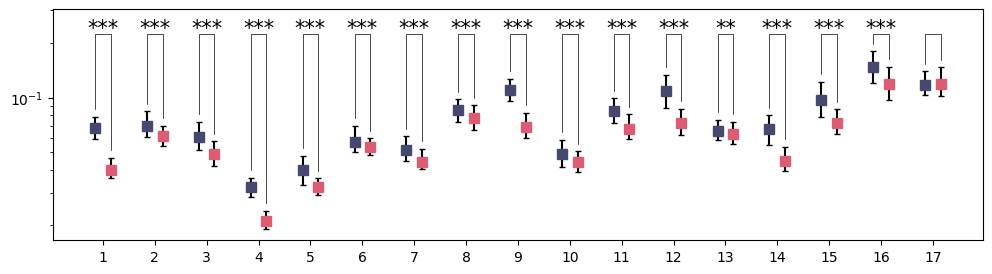

In [36]:
plt.figure(figsize = (12, 3))
plot_Wassdist('CPM', 'CAM', 'vi')

### Comparison CAM and CPM in reconstructing birth-division volumes dependence 

In [ ]:
W_vb = []

index = [0, 2, 6, 8]
k = 0
plt.figure(figsize=(12, 6))
for data in [MG_acet, MG_glu, BW_gly, BW_glu8a]:
    np.random.seed(123)
    N = np.size(data['Size at division'])
    vd = np.reshape(data['Size at division'], (N,1))
    vb = np.reshape(data['Size at birth'], (N,1))
    vi = np.reshape(data['Size at initiation per ori'], (N,1))
    Lamb = np.reshape(data['Elongation rate over C+D period'], (N,1))
    
        
    vd_sim_CPM = simu_division_size_CPM(vb, vi, Lamb, Results_parameters_estimation_CPM['parameters'][index[k]])
    vd_sim_CAM = simu_division_size_CAM(vb, vi, Results_parameters_estimation_CAM['parameters'][index[k]])
    W_vb.append(wasserstein_distance(np.concatenate((vd_sim_CPM, vb), axis = 1), np.concatenate((vd, vb), axis = 1)))
    W_vb.append(wasserstein_distance(np.concatenate((vd_sim_CAM, vb), axis = 1), np.concatenate((vd, vb), axis = 1)))
    

    ylim = (np.mean(vd) - 4*np.std(vd), np.mean(vd) + 4*np.std(vd))
    xlim = (np.mean(vb) - 4*np.std(vb), np.mean(vb) + 4*np.std(vb))
        
    plt.subplot(3, 4 , k+1)
    sns.kdeplot(x=vb.flatten(), y=vd.flatten(), fill = True, cmap=custom_cmap_data)
    plt.grid(color ='k', linewidth = 0.1)
    plt.ylim(ylim)
    plt.xlim(xlim)

    plt.subplot(3, 4 , k+5)
    sns.kdeplot(x=vb.flatten(), y=vd_sim_CAM.flatten(), fill = True, cmap=custom_cmap_CAM)
    plt.grid(color ='k', linewidth = 0.1)
    plt.ylim(ylim)
    plt.xlim(xlim)

    plt.subplot(3, 4, k+9)
    sns.kdeplot(x=vb.flatten(), y=vd_sim_CPM.flatten(), fill = True, cmap=custom_cmap_CPM)
    plt.grid(color ='k', linewidth = 0.1)
    plt.ylim(ylim)
    plt.xlim(xlim)
    k+=1
        
        
plt.savefig('plot_emp_distrib_vb.pdf', format = 'pdf')
plt.show()

W_vb = np.array(W_vb)

plt.figure(figsize=(2, 2), dpi=80)
plt.scatter([1,2,3,4], W_vb[::2], c = '#45496F', marker = 's')
plt.scatter([1,2,3,4], W_vb[1::2], c = '#DC5D71', marker = 's')
plt.ylim(0, 0.15)
plt.xlim(0, 4.5)
plt.savefig('Wass_dist_emp_distrib_vb.pdf', format = 'pdf')
plt.show()

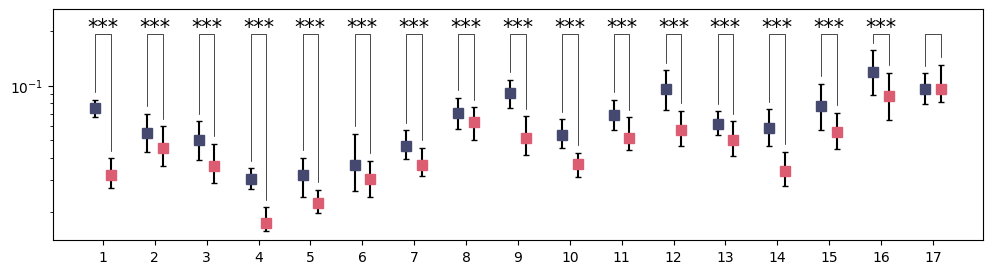

In [38]:
plt.figure(figsize = (12, 3))
plot_Wassdist('CPM', 'CAM', 'vb')

### Comparison of Wasserstein distance between DIAM/RDAM and CPM

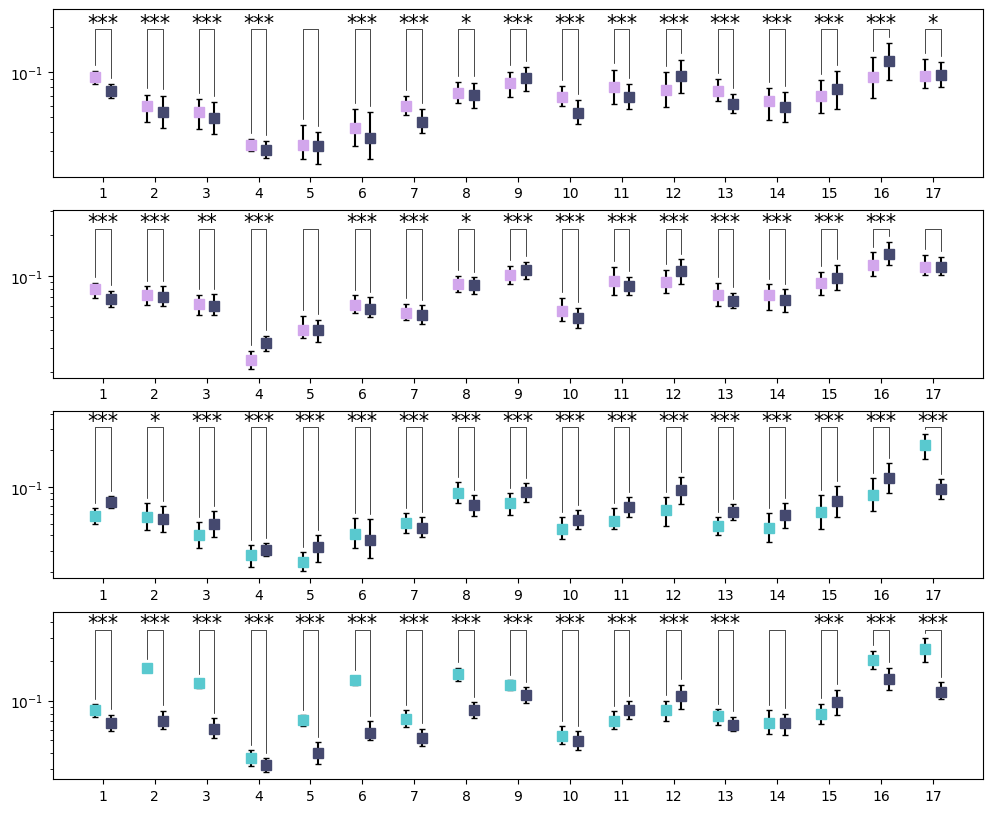

In [39]:
plt.figure(figsize = (12, 10))
plt.subplot(411)
plot_Wassdist('DIAM', 'CPM', 'vb')
plt.subplot(412)
plot_Wassdist('DIAM', 'CPM', 'vi')
plt.subplot(413)
plot_Wassdist('RDAM', 'CPM', 'vb')
plt.subplot(414)
plot_Wassdist('RDAM', 'CPM', 'vi')
plt.savefig('Wass_dist_CPM_DIAM_RDAM.pdf', format = 'pdf')

### Comparison of Wasserstein distance between DIAM/RDAM and CAM

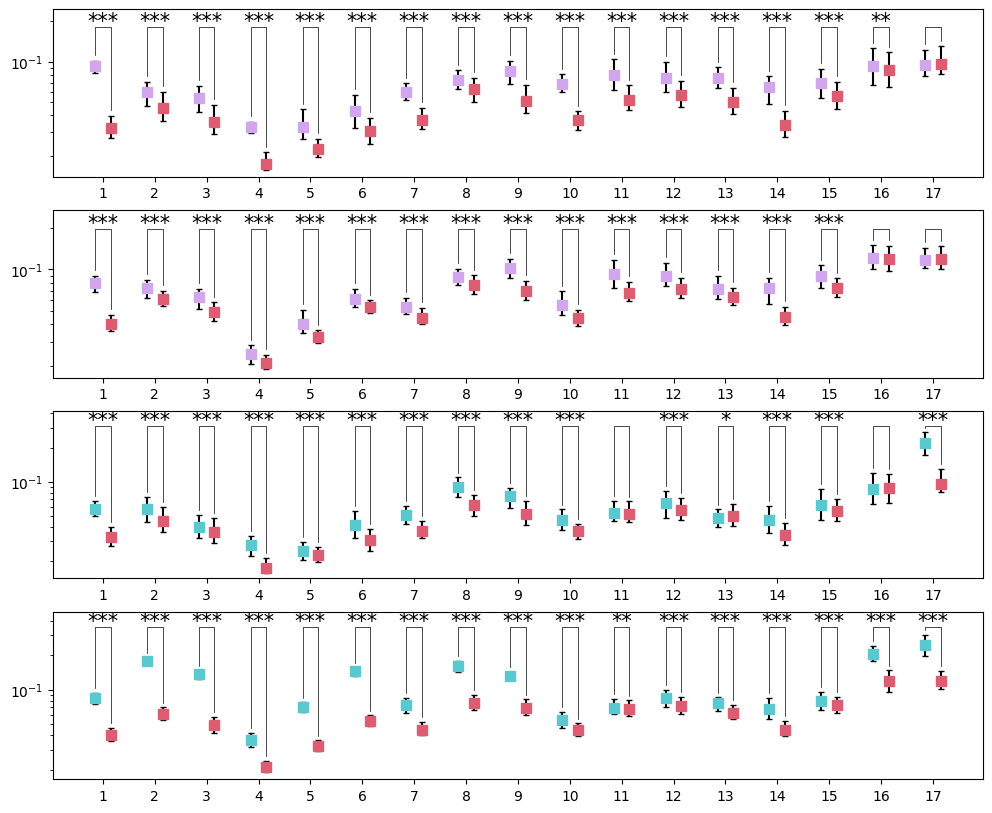

In [40]:
plt.figure(figsize = (12, 10))
plt.subplot(411)
plot_Wassdist('DIAM', 'CAM', 'vb')
plt.subplot(412)
plot_Wassdist('DIAM', 'CAM', 'vi')
plt.subplot(413)
plot_Wassdist('RDAM', 'CAM', 'vb')
plt.subplot(414)
plot_Wassdist('RDAM', 'CAM', 'vi')
plt.savefig('Wass_dist_CAM_DIAM_RDAM.pdf', format = 'pdf')

## 7. Simulation of the CAM under oscillating expression of DnaA

We introduce a function able to collect observations of $\Delta_i$ from datasets of Si et al. This function takes into argument the original data of Si et al. (e.g. data_si_mg_acet).

In [41]:
def Delta_i_observations_si(data):
    index = np.where(data[1:, data[0] == 'cell ID'] == data[0:-1, data[0] == 'daughter ID'])[0]
    vi_1 = data[index, data[0] == 'initiation size per ori (micron)']
    vi_2 = data[index+1, data[0] == 'initiation size per ori (micron)']
    return vi_2 - vi_1/2.

In [42]:
Delta_i_obs = Delta_i_observations_si(data_si_mg_glu).astype(float)
lamb_i,beta_i, sig_i = GenGamma_fit(Delta_i_obs.flatten())
param_CAM = Results_parameters_estimation_CAM['parameters'][1]

def perturb_funct(T):
    T_rescaled = 0.5*T*lamb/np.log(2)
    return np.where((T_rescaled > 5)&(np.floor(T_rescaled - 1)%2 == 0), fact_pert, 1)
    
def simu_Delta_i_Perturbed(ti):
    Nsample = np.size(ti)
    return GenGamma_rvs((1, Nsample), lamb_i,beta_i, sig_i)*perturb_funct(ti)

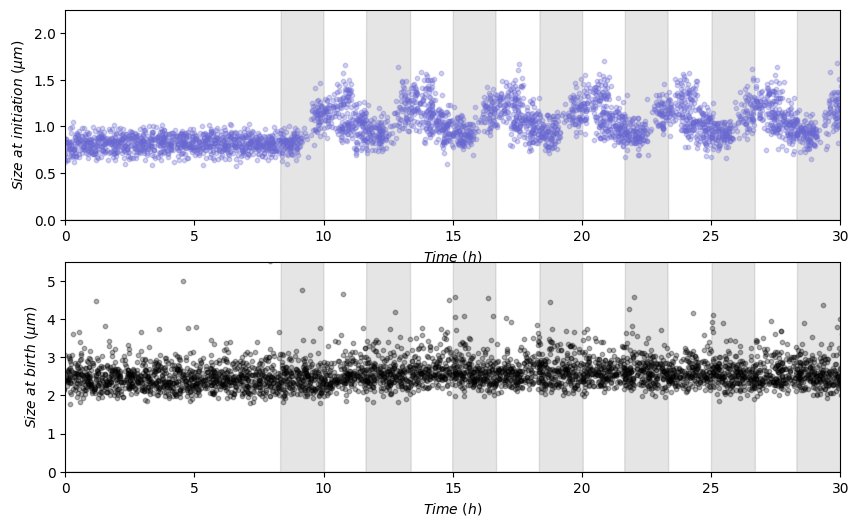

In [43]:
np.random.seed(123)
lamb = np.mean(MG_glu['Elongation rate over C+D period'])
Nb_lineages = 100
Nb_gen = 40
fact_pert = 1.75
Vi = stats.gaussian_kde(MG_glu['Size at initiation per ori'].flatten()).resample(size=Nb_lineages)
Vb = stats.gaussian_kde(MG_glu['Size at birth'].flatten()).resample(size=Nb_lineages)
Ti = -(np.random.rand(1, Nb_lineages))*np.log(2)/lamb
Tb = Ti + np.log(Vb/(2*Vi))/lamb

for i in range(Nb_gen):
    Vb_new = simu_division_size_CAM(Vb[-1,:], Vi[-1,:], param_CAM)/2.
    Vb_new = np.reshape(Vb_new, (1, Nb_lineages))
    Vi_new = (Vi[-1,:] +  simu_Delta_i_Perturbed(Ti[-1, :]))/2.
    Tb_new = Tb[-1,:] + np.log(2*Vb_new/Vb[-1,:])/lamb
    Ti_new = Ti[-1,:] + np.log(2*Vi_new/Vi[-1,:])/lamb
    Vb = np.concatenate((Vb, Vb_new), axis = 0)
    Tb = np.concatenate((Tb, Tb_new), axis = 0)
    Vi = np.concatenate((Vi, Vi_new), axis = 0)
    Ti = np.concatenate((Ti, Ti_new), axis = 0)
    

TT = np.linspace(0, 30, 600)

region_pert = np.where(Ti[:-1, :] > 5*np.log(2)/lamb)

plt.figure(figsize = (10,6))

plt.subplot(211)
plt.fill_between(TT, np.zeros(600), (perturb_funct(TT)-1)*6, color ='k', alpha = 0.1) 
plt.scatter(Ti, Vi, color = '#6968D1', s = 10, alpha = 0.3)
plt.xlim([0, 30])
plt.ylim([0, 2.25])
plt.ylabel('$Size$ $at$ $initiation$ ($\mu m$)')
plt.xlabel('$Time$ ($h$)')


plt.subplot(212)
plt.fill_between(TT, np.zeros(600), (perturb_funct(TT)-1)*13, color ='k', alpha = 0.1) 
plt.scatter(Tb, Vb, color = 'k', s = 10, alpha = 0.3)
plt.ylabel('$Size$ $at$ $birth$ ($\mu m$)')
plt.xlabel('$Time$ ($h$)')
plt.xlim([0, 30])
plt.ylim([0, 5.5])
plt.savefig('sim_oscill_CAM.pdf', format = 'pdf')


## 8. Estimation of one-origin cell division in the DIAM probability

In [44]:
def extract_donnees2(data_or_cdt, author):
    if author == 'si':
        Delta_i = Delta_i_observations_si(data_or_cdt).astype(float)
        v = data_or_cdt[1:, data_or_cdt[0] == 'newborn size (micron)'].astype(float)
        V = data_or_cdt[1:, data_or_cdt[0] == 'division size (micron)'].astype(float)
        Delta_d = V-v
        return [Delta_d.T[0], Delta_i]
    
    elif author == 'witz':
        data = data_witz[data_witz[condition] == data_or_cdt]
        data = data.dropna(subset = (dLambda_id, dLambda_if))
        data = data.to_numpy()
        data = data[:,:-1].astype(float)
        Delta_i = data[:, dLambda_if]
        Delta_d = data[:, dL]
        return [Delta_d, Delta_i]

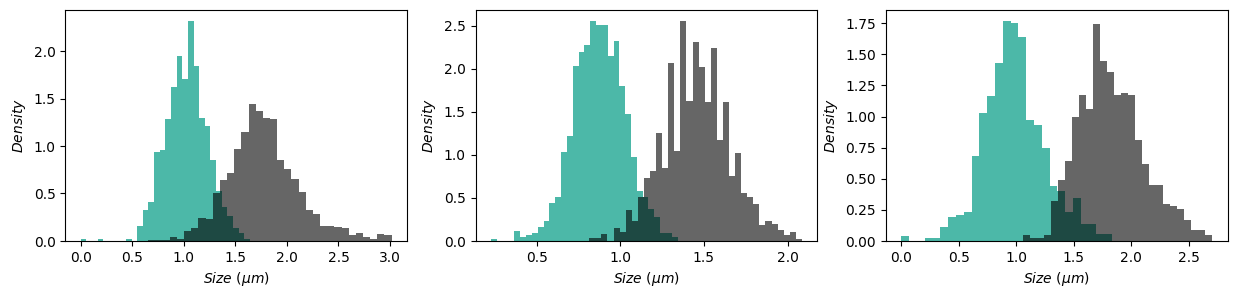

In [45]:
plt.figure(figsize = (15,3))
plt.subplot(131)
[Delta_d, Delta_i] = extract_donnees2(data_si_mg_acet, 'si')
binn = np.linspace(0, 3, 60)
histogram(Delta_i,'#009B83', 0.7)
histogram(Delta_d, 'k', 0.6)
plt.ylabel("$Density$")
plt.xlabel("$Size$ ($\mu m$)")

plt.subplot(132)
[Delta_d, Delta_i] = extract_donnees2(data_si_ncm_arg, 'si')
binn = np.linspace(0, 2.5, 60)
histogram(Delta_i,'#009B83', 0.7)
histogram(Delta_d, 'k', 0.6)
plt.ylabel("$Density$")
plt.xlabel("$Size$ ($\mu m$)")

plt.subplot(133)
[Delta_d, Delta_i] = extract_donnees2('glycerol', 'witz')
binn = np.linspace(0, 3, 60)
histogram(Delta_i,'#009B83', 0.7)
histogram(Delta_d, 'k', 0.6)
plt.ylabel("$Density$")
plt.xlabel("$Size$ ($\mu m$)")
plt.savefig('fig_overlap_densities_Delta.pdf', format = 'pdf')

In [46]:
def MonteCarlo_proba_DIAM(data_or_cdt, author, nb_sim):
    [Delta_d, Delta_i] = extract_donnees2(data_or_cdt, author)
    f_Dd = stats.gaussian_kde(Delta_d)
    f_Di = stats.gaussian_kde(Delta_i)
    Vb = f_Dd.resample(size=nb_sim)
    Vi = f_Di.resample(size=nb_sim)
    for loop in range(100):
        Vb = (Vb + f_Dd.resample(size=nb_sim))/2.
        Vi = (Vi + f_Di.resample(size=nb_sim))/2.
    Vb = np.reshape(Vb, (1, nb_sim))
    Vi = np.reshape(Vi, (1, nb_sim))
    Vb = np.concatenate((Vb, np.ones((1, nb_sim))), axis = 0)
    Vi = np.concatenate((Vi, np.zeros((1, nb_sim))), axis = 0)
    Total = np.concatenate((Vb, Vi), axis = 1)
    i = np.argsort(Total[0])
    Total = Total[:,i]
    s = np.sum(np.arange(1, 2*nb_sim + 1)*Total[1])
    plt.subplot
    plt.hist(Vb[0], [0.01*k for k in range(300)], color = 'k', density = True, alpha = 0.5)
    plt.hist(Vi[0], [0.01*k for k in range(300)], color = 'b', density = True, alpha = 0.5)
    print(1 + nb_sim*(nb_sim+1)/(2 * nb_sim**2) - s/nb_sim**2) # Wilcoxon's strategy

0.0007825518140001098
7.247680300004333e-05
0.0011451183649999752


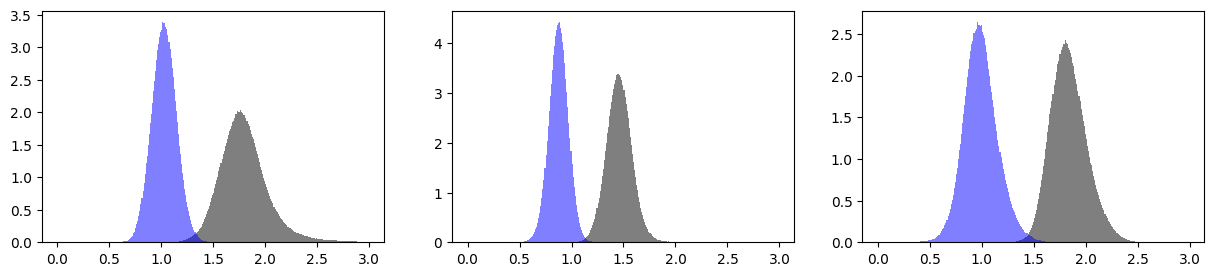

In [47]:
plt.figure(figsize = (15,3))
plt.subplot(131)
MonteCarlo_proba_DIAM(data_si_mg_acet, 'si', 1000000)
plt.subplot(132)
MonteCarlo_proba_DIAM(data_si_ncm_arg, 'si', 1000000)
plt.subplot(133)
MonteCarlo_proba_DIAM('glycerol', 'witz', 1000000)
plt.savefig('fig_overlap_densities_Vinfty.pdf', format = 'pdf')

## Saving of the estimated parameters for future uses

In [48]:
import pickle
with open('Results_parameters_estimation_DIAM.pkl', 'wb') as f:
    pickle.dump(Results_parameters_estimation_DIAM, f)

with open('Results_parameters_estimation_RDAM.pkl', 'wb') as f:
    pickle.dump(Results_parameters_estimation_RDAM, f)   
    
with open('Results_parameters_estimation_CPM.pkl', 'wb') as f:
    pickle.dump(Results_parameters_estimation_CPM, f)

with open('Results_parameters_estimation_CAM.pkl', 'wb') as f:
    pickle.dump(Results_parameters_estimation_CAM, f)

In [49]:
import pickle
with open('Results_parameters_estimation_DIAM.pkl', 'rb') as f:
    Results_parameters_estimation_DIAM = pickle.load(f)
with open('Results_parameters_estimation_RDAM.pkl', 'rb') as f:
    Results_parameters_estimation_RDAM = pickle.load(f)
with open('Results_parameters_estimation_CPM.pkl', 'rb') as f:
    Results_parameters_estimation_CPM = pickle.load(f)
with open('Results_parameters_estimation_CAM.pkl', 'rb') as f:
    Results_parameters_estimation_CAM = pickle.load(f)